In [1]:
import scipy.io

from BlockSync2 import *
import numpy as np
import pandas as pd
import scipy.io as io
import pathlib
import os
import sys
from matplotlib import pyplot as plt
import seaborn as sns
from open_ephys import analysis as oea
import bokeh
from bokeh.io import output as b_output
from bokeh.models import formatters
import scipy.signal as sig
from scipy import stats as st
import scipy.interpolate as interp
import time
from scipy.stats import kde

In [2]:
# Function definitions
def analyzed_block_automated_pipe(block):
    """This function runs all the import steps that I am already confident about for a block
    that has already gone through synchronization and dlc reading"""
    block.handle_eye_videos()
    block.handle_arena_files()
    block.parse_open_ephys_events()
    block.synchronize_arena_timestamps()
    block.create_arena_brightness_df(threshold_value=240,export=True)
    block.synchronize_block(export=True)
    block.create_eye_brightness_df(threshold_value=250)
    block.import_manual_sync_df()
    block.read_dlc_data()
    block.saccade_event_analayzer(threshold=1.5,automatic=True)

In [3]:
def long_looper_arousal_pupilDiameter_saccades(date,block_n):

    experiments_path = pathlib.Path(r"Z:\Nimrod\experiments")
    animal = "PV_24"
    block = BlockSync(animal_call=animal,
                  experiment_date=date,block_num=block_n,
                  path_to_animal_folder=str(experiments_path))
    # path definition
    p = block.oe_path / 'analysis'
    analysis_list = os.listdir(p)
    correct_analysis = [i for i in analysis_list if "PV_24" in i][0]
    p = p / str(correct_analysis)
    matPath = p / 'lizMov.mat'
    print(f'path to mat file is {matPath}')
    analyzed_block_automated_pipe(block)
    # read mat file
    matDict = io.loadmat(matPath)
    df_dict = {'t_mov_ms':matDict['t_mov_ms'][0,:],
               'movAll':matDict['movAll'][0,:]}
    df = pd.DataFrame.from_dict(df_dict)
    # The t_mov_ms column indicates the times when threshold-crossing movements occurred in Milliseconds from electrophysiology recording beginning
    # the movAll column gives the amplitude of said movements as a combination of the 3D accelerometer channels

    # It is now needed to synchronize the timebase so that 0 will be the beginning of synchronized time and not beginning of oe recording
    # first, find the very first timestamp of the oe recording
    session = oea.Session(str(block.oe_path.parent))
    rec_node = session.recordnodes[0].recordings[0].continuous[0]
    rec_starts = rec_node.timestamps[0]
    # second, find the first arena_TTL oe based timestamp
    sync_starts = block.final_sync_df.Arena_TTL[0]
    # t_mov_ms should have the Milliseconds between beginning of the recording and beginning of synchronized time subtracted to align 0 with the synctime 0
    delta_samples = sync_starts - rec_starts
    delta_samples_ms = (delta_samples / block.sample_rate)*1000
    synced_t_ms_mov = matDict['t_mov_ms'][0,:] - delta_samples_ms # correction happens here
    # now re-create the df
    df_dict = {'t_mov_ms': synced_t_ms_mov,
               'movAll': matDict['movAll'][0,:]}
    acc_df = pd.DataFrame.from_dict(df_dict)

    # collect saccade events
    block.saccade_event_analayzer(automatic=True)
    # sort the data:
    r_saccades = block.r_saccades_chunked[block.r_saccades_chunked.saccade_length_frames > 0]
    l_saccades = block.l_saccades_chunked[block.l_saccades_chunked.saccade_length_frames > 0]
    # Rolling window based saccade frequency Vs Arousal (movement magnitude)
    window_size_ms = 10000
    step_size_ms = 1000
    end_time = block.re_df.ms_axis.iloc[-1]
    flag = False
    t0 = 0
    window_dict = {
        'mid_time': [],
        'window_size': [],
        'saccade_count_l':[],
        'saccade_count_r':[],
        'pupil_diameter_r': [],
        'pupil_diameter_l': [],
        'mov_magnitude':[]
    }
    while flag is False:
        bin = [t0, t0+window_size_ms] # define the time window for the computation
        print(bin,end='\r')
        ms_timestamp = t0 + (window_size_ms/2) # place a timestamp in the middle of the window, maybe use later for sequential stuff
        saccade_count_r = len(r_saccades.query('saccade_start_ms > @bin[0] and saccade_start_ms < @bin[1]'))
        saccade_count_l = len(l_saccades.query('saccade_start_ms > @bin[0] and saccade_start_ms < @bin[1]'))
        mov_magnitude = np.sum(acc_df.query('t_mov_ms > @bin[0] and t_mov_ms < @bin[1]').movAll.values)
        pupil_diameter_r = np.mean(block.re_df.query('ms_axis > @bin[0] and ms_axis < @bin[1]').ellipse_size)
        pupil_diameter_l = np.mean(block.le_df.query('ms_axis > @bin[0] and ms_axis < @bin[1]').ellipse_size)

        t0 += step_size_ms

        # add to window dict
        window_dict['mid_time'].append(ms_timestamp)
        window_dict['window_size'].append(window_size_ms)
        window_dict['saccade_count_l'].append(saccade_count_l)
        window_dict['saccade_count_r'].append(saccade_count_r)
        window_dict['mov_magnitude'].append(mov_magnitude)
        window_dict['pupil_diameter_l'].append(pupil_diameter_l)
        window_dict['pupil_diameter_r'].append(pupil_diameter_r)

        if t0+window_size_ms > end_time:
            flag = True
            continue
        else:
            t0 += step_size_ms
            continue
    win_df = pd.DataFrame(window_dict)
    export_path = pathlib.Path(r"Z:\Nimrod\experiments\PV_24_overall_analysis")
    win_df.to_csv(str(export_path / block.block_num) + '.csv')

def multi_block_saccade_dict_creationV3(blocklist, ep_channel=17):

    saccade_dict = {}
    # loop over the blocks from here:
    for block in blocklist:
        # collect accelerometer data
        # path definition
        p = block.oe_path / 'analysis'
        analysis_list = os.listdir(p)
        correct_analysis = [i for i in analysis_list if "PV_24" in i][0]
        p = p / str(correct_analysis)
        matPath = p / 'lizMov.mat'
        print(f'path to mat file is {matPath}')
        # read mat file
        matDict = io.loadmat(matPath)
        # df_dict = {'t_mov_ms':matDict['t_mov_ms'][0,:],
        #            'movAll':matDict['movAll'][0,:]}
        # df = pd.DataFrame.from_dict(df_dict)

        # The t_mov_ms column indicates the times when threshold-crossing movements occurred in Milliseconds from electrophysiology recording beginning
        # the movAll column gives the amplitude of said movements as a combination of the 3D accelerometer channels

        # It is now needed to synchronize the timebase so that 0 will be the beginning of synchronized time and not beginning of oe recording
        # first, find the very first timestamp of the oe recording
        session = oea.Session(str(block.oe_path.parent))
        rec_node = session.recordnodes[0].recordings[0].continuous[0]
        rec_starts = rec_node.timestamps[0]
        # second, find the first arena_TTL oe based timestamp
        sync_starts = block.final_sync_df.Arena_TTL[0]
        # t_mov_ms should have the Milliseconds between beginning of the recording and beginning of synchronized time subtracted to align 0 with the synctime 0
        delta_samples = sync_starts - rec_starts
        delta_samples_ms = (delta_samples / block.sample_rate)*1000
        synced_t_ms_mov = matDict['t_mov_ms'][0,:] - delta_samples_ms # correction happens here
        # now create the df and delete the dict
        df_dict = {'t_mov_ms': synced_t_ms_mov,
                   'movAll': matDict['movAll'][0,:]}
        acc_df = pd.DataFrame.from_dict(df_dict)
        del df_dict

        # collect saccade events
        block.saccade_event_analayzer(automatic=True,threshold=2)

        # get all the electrophysiology data of a single electrode:
        print(f'getting EP data from block {block.block_num}')
        #session = oea.Session(str(block.oe_path.parent))
        data = session.recordnodes[0].recordings[0].continuous[0].samples[:,ep_channel]
        timestamps = session.recordnodes[0].recordings[0].continuous[0].timestamps
        print('done')

        # create the top-level block dict object
        block_dict = {
            'L':{},
            'R':{}
        }

        # create and populate the internal dictionaries (for each eye)
        for i, e in enumerate(['L','R']):
            # get the correct saccades_chunked object and eye_df
            saccades_chunked = [block.l_saccades_chunked,block.r_saccades_chunked][i]
            eye_df = [block.le_df,block.re_df][i]
            saccades = saccades_chunked[saccades_chunked.saccade_length_frames > 0]
            saccade_times = np.sort(saccades.saccade_start_ms.values)
            saccade_ts = eye_df[eye_df['ms_axis'].isin(saccade_times)].Arena_TTL.values

            # now use the saccade_ts vector to choose samples with a given segment length before and after the saccades
            seg_seconds = 2
            segment_length = seg_seconds*block.sample_rate #samples
            before_saccade_ts = saccade_ts - segment_length
            after_saccade_ts = saccade_ts + segment_length

            # start populating the dictionary
            block_dict[e] = {
                "timestamps":[],
                "fs":[],
                "pxx":[],
                "samples":[],
                "x_coords":[],
                "y_coords":[],
                "vid_inds":[],
                "accel":[]
            }

            # go saccade by saccade
            for i in tqdm(range(len(saccade_ts))):

                # define the segment range
                pre_saccade_sample_ind = np.where(timestamps == int(before_saccade_ts[i]))[0][0]
                post_saccade_sample_ind = np.where(timestamps == int(after_saccade_ts[i]))[0][0]
                samples_range = range(pre_saccade_sample_ind,post_saccade_sample_ind)
                segment_samples = data[samples_range]

                # get the spectral profile for the segment
                fs, pxx = sig.welch(segment_samples,block.sample_rate,nperseg=16384,return_onesided=True)

                # get x and y coordinates for the segment and their indices inside the segment (without reference)
                i0 = saccade_ts[i] - (block.sample_rate*2)
                i1 = saccade_ts[i] + (block.sample_rate*2)
                s_df = eye_df.query("Arena_TTL >= @i0 and Arena_TTL <= @i1")
                vid_inds = np.array((s_df.Arena_TTL.values - saccade_ts[i]) + segment_length, dtype='int32')
                x_coords = s_df.center_x.values
                y_coords = s_df.center_y.values

                # deal with missing values here:
                interpolated_coords = []
                bad_saccade = False
                for y in [x_coords, y_coords]:
                    nan_count = np.sum(np.isnan(y))
                    if nan_count > 0 :
                        if nan_count < len(y)/2:
                            #print(f'saccade at ind {i} has {nan_count} nans, interpolating...')
                            # find nan values in the vector
                            nans, z = nan_helper(y)
                            # interpolate using the helper lambda function
                            y[nans] = np.interp(z(nans),z(~nans),y[~nans])
                            # replace the interpolated values for the saccade
                            interpolated_coords.append(y)
                        else:
                            print(f'too many nans at ind {i}, ({np.sum(np.isnan(y))}) - cannot interpolate properly',end='\r',flush=True)
                            bad_saccade = True
                    else:
                        interpolated_coords.append(y)

                # get accelerometer data for the ms_based section:
                # get_ms_segment
                ms_segment = s_df['ms_axis']
                s0 = ms_segment.iloc[0]
                s1 = ms_segment.iloc[-1]
                mov_mag = np.sum(acc_df.query('t_mov_ms > @s0 and t_mov_ms < @s1').movAll.values)

                # remove bad saccades
                if bad_saccade:
                    continue
                # append OK saccades
                else:
                    block_dict[e]['timestamps'].append(saccade_ts[i])
                    block_dict[e]['x_coords'].append(interpolated_coords[0])
                    block_dict[e]['y_coords'].append(interpolated_coords[1])
                    block_dict[e]['vid_inds'].append(vid_inds)
                    block_dict[e]['fs'].append(fs)
                    block_dict[e]['pxx'].append(pxx)
                    block_dict[e]['samples'].append(segment_samples)
                    block_dict[e]['accel'].append(mov_mag)
        saccade_dict[block.block_num] = block_dict
    return saccade_dict

In [4]:
def long_looper_arousal_pupilDiameter(date,block_n):

    experiments_path = pathlib.Path(r"Z:\Nimrod\experiments")
    animal = "PV_24"
    block = BlockSync(animal_call=animal,
                  experiment_date=date,block_num=block_n,
                  path_to_animal_folder=str(experiments_path))
    # path definition
    p = block.oe_path / 'analysis'
    analysis_list = os.listdir(p)
    correct_analysis = [i for i in analysis_list if "PV_24" in i][0]
    p = p / str(correct_analysis)
    matPath = p / 'lizMov.mat'
    print(f'path to mat file is {matPath}')
    analyzed_block_automated_pipe(block)
    # read mat file
    matDict = io.loadmat(matPath)
    df_dict = {'t_mov_ms':matDict['t_mov_ms'][0,:],
               'movAll':matDict['movAll'][0,:]}
    df = pd.DataFrame.from_dict(df_dict)
    # The t_mov_ms column indicates the times when threshold-crossing movements occurred in Milliseconds from electrophysiology recording beginning
    # the movAll column gives the amplitude of said movements as a combination of the 3D accelerometer channels

    # It is now needed to synchronize the timebase so that 0 will be the beginning of synchronized time and not beginning of oe recording
    # first, find the very first timestamp of the oe recording
    session = oea.Session(str(block.oe_path.parent))
    rec_node = session.recordnodes[0].recordings[0].continuous[0]
    rec_starts = rec_node.timestamps[0]
    # second, find the first arena_TTL oe based timestamp
    sync_starts = block.final_sync_df.Arena_TTL[0]
    # t_mov_ms should have the Milliseconds between beginning of the recording and beginning of synchronized time subtracted to align 0 with the synctime 0
    delta_samples = sync_starts - rec_starts
    delta_samples_ms = (delta_samples / block.sample_rate)*1000
    synced_t_ms_mov = matDict['t_mov_ms'][0,:] - delta_samples_ms # correction happens here
    # now re-create the df
    df_dict = {'t_mov_ms': synced_t_ms_mov,
               'movAll': matDict['movAll'][0,:]}
    acc_df = pd.DataFrame.from_dict(df_dict)


    # Rolling window based pupil diameter Vs Arousal (movement magnitude)
    window_size_ms = 10000
    step_size_ms = 1000
    end_time = block.re_df.ms_axis.iloc[-1]
    flag = False
    t0 = 0
    window_dict = {
        'mid_time': [],
        'window_size': [],
        'pupil_diameter_r': [],
        'pupil_diameter_l': [],
        'mov_magnitude':[]
    }
    while flag is False:
        bin = [t0, t0+window_size_ms] # define the time window for the computation
        print(bin,end='\r')
        ms_timestamp = t0 + (window_size_ms/2) # place a timestamp in the middle of the window, maybe use later for sequential stuff
        mov_magnitude = np.sum(acc_df.query('t_mov_ms > @bin[0] and t_mov_ms < @bin[1]').movAll.values)
        pupil_diameter_r = np.mean(block.re_df.query('ms_axis > @bin[0] and ms_axis < @bin[1]').ellipse_size)
        pupil_diameter_l = np.mean(block.le_df.query('ms_axis > @bin[0] and ms_axis < @bin[1]').ellipse_size)

        t0 += step_size_ms

        # add to window dict
        window_dict['mid_time'].append(ms_timestamp)
        window_dict['window_size'].append(window_size_ms)
        window_dict['mov_magnitude'].append(mov_magnitude)
        window_dict['pupil_diameter_l'].append(pupil_diameter_l)
        window_dict['pupil_diameter_r'].append(pupil_diameter_r)

        if t0+window_size_ms > end_time:
            flag = True
            continue
        else:
            t0 += step_size_ms
            continue
    win_df = pd.DataFrame(window_dict)
    export_path = pathlib.Path(r"Z:\Nimrod\experiments\PV_24_overall_analysis_NoSaccades")
    win_df.to_csv(str(export_path / block.block_num) + '.csv')

In [5]:
def multi_block_saccade_dict_pre_post_creation(blocklist):

    saccade_dict = {}
    # loop over the blocks from here:
    for block in blocklist:

        # collect saccade events
        block.saccade_event_analayzer(automatic=True,threshold=2)

        # collect timestamps of saccades
        l_saccades = block.l_saccades_chunked[block.l_saccades_chunked.saccade_length_frames > 0]
        r_saccades = block.r_saccades_chunked[block.r_saccades_chunked.saccade_length_frames > 0]
        saccade_times = np.sort(np.concatenate([l_saccades.saccade_start_ms.values,r_saccades.saccade_start_ms.values]))
        saccade_ts = block.re_df[block.re_df['ms_axis'].isin(saccade_times)].Arena_TTL.values # translate saccade times to sample based timestamps

        # get all the electrophysiology data of a single electrode:
        print(f'getting EP data from block {block.block_num}')
        session = oea.Session(str(block.oe_path.parent))
        data = session.recordnodes[0].recordings[0].continuous[0].samples[:,17]
        timestamps = session.recordnodes[0].recordings[0].continuous[0].timestamps
        print('done')
        # now use the saccade_ts vector to choose samples with a given segment length before and after the saccades
        segment_length = 40000 #samples
        before_saccade_ts = saccade_ts - segment_length
        after_saccade_ts = saccade_ts + segment_length
        pre_dict = {
            "timestamps":saccade_ts,
            "fs":[],
            "pxx":[],
            "samples":[],
            "x_coords":[],
            "y_coords":[]
        }
        post_dict = {
            "timestamps":saccade_ts,
            "fs":[],
            "pxx":[],
            "samples":[],
            "x_coords":[],
            "y_coords":[]
        }
        for i in tqdm(range(len(saccade_ts))):
            saccade_sample_ind = np.where(timestamps == int(saccade_ts[i]))[0][0]
            pre_saccade_sample_ind = np.where(timestamps == int(before_saccade_ts[i]))[0][0]
            post_saccade_sample_ind = np.where(timestamps == int(after_saccade_ts[i]))[0][0]
            pre_samples_range = range(pre_saccade_sample_ind,saccade_sample_ind)
            post_samples_range = range(saccade_sample_ind, post_saccade_sample_ind)
            pre_segment_samples = data[pre_samples_range]
            post_segment_samples = data[post_samples_range]

            pre_fs, pre_pxx = sig.welch(pre_segment_samples,block.sample_rate,nperseg=16384,return_onesided=True)
            post_fs, post_pxx = sig.welch(post_segment_samples,block.sample_rate,nperseg=16384,return_onesided=True)
            pre_dict['fs'].append(pre_fs)
            pre_dict['pxx'].append(pre_pxx)
            post_dict['fs'].append(post_fs)
            post_dict['pxx'].append(post_pxx)
            pre_dict['samples'].append(pre_segment_samples)
            post_dict['samples'].append(post_segment_samples)
        saccade_dict[block.block_num] = [pre_dict, post_dict]
    return saccade_dict

In [6]:
def block_generator(block_list,experiment_path,animal, bad_blocks=[]):
    """
    creates a block_collection to iterate over with multi-block functions
    :param block_list: list of block numbers to loop over
    :param experiment_path: pathlib.Path instance to the experiment folder
    :param animal: string
    :param bad_blocks: blocks to ignore
    :return:
    """
    p = pathlib.Path(experiment_path) / animal
    date_folder_list = [i for i in p.iterdir() if 'block' not in str(i).lower() and i.is_dir()]
    block_collection = []
    for date_path in date_folder_list:
        date = date_path.name
        # list all the blocks in the folder:
        folder_list = [i for i in date_path.iterdir()]
        for block in folder_list:
            block_number = block.name[-3:]
            if int(block_number) in block_list and int(block_number) not in bad_blocks:
                #block definition
                block = BlockSync(animal_call=animal,
                                  experiment_date=date,block_num=block_number,
                                  path_to_animal_folder=str(experiment_path))
                block_collection.append(block)
    return block_collection

In [7]:
def multi_block_saccade_dict_creation(blocklist, ep_channel=17):

    saccade_dict = {}
    # loop over the blocks from here:
    for block in blocklist:

        # collect saccade events
        block.saccade_event_analayzer(automatic=True,threshold=2)

        # collect timestamps of saccades
        l_saccades = block.l_saccades_chunked[block.l_saccades_chunked.saccade_length_frames > 0]
        r_saccades = block.r_saccades_chunked[block.r_saccades_chunked.saccade_length_frames > 0]
        saccade_times = np.sort(np.concatenate([l_saccades.saccade_start_ms.values,r_saccades.saccade_start_ms.values]))
        saccade_ts = block.re_df[block.re_df['ms_axis'].isin(saccade_times)].Arena_TTL.values # translate saccade times to sample based timestamps

        # get all the electrophysiology data of a single electrode:
        print(f'getting EP data from block {block.block_num}')
        session = oea.Session(str(block.oe_path.parent))
        data = session.recordnodes[0].recordings[0].continuous[0].samples[:,ep_channel]
        timestamps = session.recordnodes[0].recordings[0].continuous[0].timestamps
        print('done')

        # now use the saccade_ts vector to choose samples with a given segment length before and after the saccades
        seg_seconds = 2
        segment_length = seg_seconds*block.sample_rate #samples
        before_saccade_ts = saccade_ts - segment_length
        after_saccade_ts = saccade_ts + segment_length
        b_dict = {
            "timestamps":saccade_ts,
            "fs":[],
            "pxx":[],
            "samples":[],
            "rx_coords":[],
            "ry_coords":[],
            "lx_coords":[],
            "ly_coords":[],
            "r_vid_inds":[],
            "l_vid_inds":[]
        }

        # go saccade by saccade
        for i in tqdm(range(len(saccade_ts))):

            # define the segment range
            pre_saccade_sample_ind = np.where(timestamps == int(before_saccade_ts[i]))[0][0]
            post_saccade_sample_ind = np.where(timestamps == int(after_saccade_ts[i]))[0][0]
            samples_range = range(pre_saccade_sample_ind,post_saccade_sample_ind)
            segment_samples = data[samples_range]

            # get the spectral profile for the segment
            fs, pxx = sig.welch(segment_samples,block.sample_rate,nperseg=16384,return_onesided=True)

            # get x and y coordinates for the segment and their indices inside the segment (without reference)
            i0 = saccade_ts[i] - (block.sample_rate*2)
            i1 = saccade_ts[i] + (block.sample_rate*2)
            rs_df = block.re_df.query("Arena_TTL >= @i0 and Arena_TTL <= @i1")
            ls_df = block.le_df.query("Arena_TTL >= @i0 and Arena_TTL <= @i1")
            r_vid_inds = np.array((rs_df.Arena_TTL.values - saccade_ts[i]) + segment_length, dtype='int32')
            l_vid_inds = np.array((ls_df.Arena_TTL.values - saccade_ts[i]) + segment_length, dtype='int32')
            b_dict['rx_coords'].append(rs_df.center_x.values)
            b_dict['ry_coords'].append(rs_df.center_y.values)
            b_dict['lx_coords'].append(ls_df.center_x.values)
            b_dict['ly_coords'].append(ls_df.center_y.values)
            b_dict['r_vid_inds'].append(r_vid_inds)
            b_dict['l_vid_inds'].append(l_vid_inds)
            b_dict['fs'].append(fs)
            b_dict['pxx'].append(pxx)
            b_dict['samples'].append(segment_samples)
        saccade_dict[block.block_num] = b_dict
    return saccade_dict

In [8]:
def nan_helper(y):
    """Helper to handle indices and logical indices of NaNs.

    Input:
        - y, 1d numpy array with possible NaNs
    Output:
        - nans, logical indices of NaNs
        - index, a function, with signature indices= index(logical_indices),
          to convert logical indices of NaNs to 'equivalent' indices
    """
    return np.isnan(y), lambda z: z.nonzero()[0]

def multi_block_saccade_dict_creationV2(blocklist, ep_channel=17):

    saccade_dict = {}
    # loop over the blocks from here:
    for block in blocklist:

        # collect saccade events
        block.saccade_event_analayzer(automatic=True,threshold=2)

        # get all the electrophysiology data of a single electrode:
        print(f'getting EP data from block {block.block_num}')
        session = oea.Session(str(block.oe_path.parent))
        data = session.recordnodes[0].recordings[0].continuous[0].samples[:,ep_channel]
        timestamps = session.recordnodes[0].recordings[0].continuous[0].timestamps
        print('done')

        # create the top-level block dict object
        block_dict = {
            'L':{},
            'R':{}
        }

        # create and populate the internal dictionaries (for each eye)
        for i, e in enumerate(['L','R']):
            # get the correct saccades_chunked object and eye_df
            saccades_chunked = [block.l_saccades_chunked,block.r_saccades_chunked][i]
            eye_df = [block.le_df,block.re_df][i]
            saccades = saccades_chunked[saccades_chunked.saccade_length_frames > 0]
            saccade_times = np.sort(saccades.saccade_start_ms.values)
            saccade_ts = eye_df[eye_df['ms_axis'].isin(saccade_times)].Arena_TTL.values

            # now use the saccade_ts vector to choose samples with a given segment length before and after the saccades
            seg_seconds = 2
            segment_length = seg_seconds*block.sample_rate #samples
            before_saccade_ts = saccade_ts - segment_length
            after_saccade_ts = saccade_ts + segment_length

            # start populating the dictionary
            block_dict[e] = {
                "timestamps":[],
                "fs":[],
                "pxx":[],
                "samples":[],
                "x_coords":[],
                "y_coords":[],
                "vid_inds":[]
            }

            # go saccade by saccade
            for i in tqdm(range(len(saccade_ts))):

                # define the segment range
                pre_saccade_sample_ind = np.where(timestamps == int(before_saccade_ts[i]))[0][0]
                post_saccade_sample_ind = np.where(timestamps == int(after_saccade_ts[i]))[0][0]
                samples_range = range(pre_saccade_sample_ind,post_saccade_sample_ind)
                segment_samples = data[samples_range]

                # get the spectral profile for the segment
                fs, pxx = sig.welch(segment_samples,block.sample_rate,nperseg=16384,return_onesided=True)

                # get x and y coordinates for the segment and their indices inside the segment (without reference)
                i0 = saccade_ts[i] - (block.sample_rate*2)
                i1 = saccade_ts[i] + (block.sample_rate*2)
                s_df = eye_df.query("Arena_TTL >= @i0 and Arena_TTL <= @i1")
                vid_inds = np.array((s_df.Arena_TTL.values - saccade_ts[i]) + segment_length, dtype='int32')
                x_coords = s_df.center_x.values
                y_coords = s_df.center_y.values

                # deal with missing values here:
                interpolated_coords = []
                bad_saccade = False
                for y in [x_coords, y_coords]:
                    nan_count = np.sum(np.isnan(y))
                    if nan_count > 0 :
                        if nan_count < len(y)/2:
                            #print(f'saccade at ind {i} has {nan_count} nans, interpolating...')
                            # find nan values in the vector
                            nans, z = nan_helper(y)
                            # interpolate using the helper lambda function
                            y[nans] = np.interp(z(nans),z(~nans),y[~nans])
                            # replace the interpolated values for the saccade
                            interpolated_coords.append(y)
                        else:
                            print(f'too many nans at ind {i}, ({np.sum(np.isnan(y))}) - cannot interpolate properly')
                            bad_saccade = True
                    else:
                        interpolated_coords.append(y)


                # remove bad saccades
                if bad_saccade:
                    continue
                # append OK saccades
                else:
                    block_dict[e]['timestamps'].append(saccade_ts[i])
                    block_dict[e]['x_coords'].append(interpolated_coords[0])
                    block_dict[e]['y_coords'].append(interpolated_coords[1])
                    block_dict[e]['vid_inds'].append(vid_inds)
                    block_dict[e]['fs'].append(fs)
                    block_dict[e]['pxx'].append(pxx)
                    block_dict[e]['samples'].append(segment_samples)
        saccade_dict[block.block_num] = block_dict
    return saccade_dict

In [9]:
def find_closest_diff(x,vals):
    """

    :param x: some value
    :param vals: list of values to choose from
    :return: min_diff: the minimal distance between x and the vals
    :return: ind: location in vals of the minimal difference
    """
    vals = np.array(vals)
    diff_vals = vals - x
    min_diff = np.amin(diff_vals)
    ind = np.where(diff_vals == min_diff)
    return min_diff, ind

def sort_synced_saccades(b_dict):
    """
    This function takes a saccades dictionary and returns two sorted dictionaries - one with synced saccades, the other with non-synced saccades
    :param b_dict:
    :return:
    """
    # get the two timestamps vectors
    l_times = np.array(b_dict['L']['timestamps'])
    r_times = np.array(b_dict['R']['timestamps'])

    # I want to collect the matching indices from the L and R dictionaries and create a "synced saccades dict" object that only has two-eyed saccades included in it
    # first, I have to understand which rows of the dictionaries go together:
    # create a matrix of [left eye timestamp, -,left eye ind, -]
    s_mat = np.empty([len(l_times),5])
    s_mat[:,0] = l_times
    s_mat[:,2] = np.arange(0,len(l_times))
    # find and fit the right eye times and indices on columns 1 and 3
    for i, lt in enumerate(s_mat[:,0]):
        array = np.abs((r_times - lt))
        ind_min_diff = np.argmin(array)
        min_diff = array[ind_min_diff]
        rt = r_times[ind_min_diff]
        s_mat[i,3] = ind_min_diff
        s_mat[i,1] = rt
        s_mat[i,4] = min_diff

    # create a dataframe for queries and testing, define a threshold and remove non sync saccades
    s_df = pd.DataFrame(s_mat,columns=['lt','rt','left_ind','right_ind','diff'])
    threshold = 1400 # 70 ms to consider a saccade simultaneous
    s_df = s_df.query('diff<@threshold')
    ind_dict = {
        'L':s_df['left_ind'].values,
        'R':s_df['right_ind'].values
    }

    # create a synced dictionary for the block:
    synced_b_dict = {
        'L':{},
        'R':{}
    }
    for e in ['L','R']:
        inds = ind_dict[e].astype(int)
        synced_b_dict[e] = {
            "timestamps":np.array(b_dict[e]['timestamps'])[inds],
            "fs":np.array(b_dict[e]['fs'])[inds],
            "pxx":np.array(b_dict[e]['pxx'])[inds],
            "samples":np.array(b_dict[e]['samples'])[inds],
            "x_coords":np.array(b_dict[e]['x_coords'])[inds],
            "y_coords":np.array(b_dict[e]['y_coords'])[inds],
            "vid_inds":np.array(b_dict[e]['vid_inds'])[inds],
            "accel":np.array(b_dict[e]['accel'])[inds]
        }

    non_sync_b_dict = {
        'L':{},
        'R':{}
    }
    for e in ['L','R']:
        inds = ind_dict[e].astype(int)
        logical = np.ones(len(b_dict[e]['timestamps'])).astype(np.bool)
        logical[inds] = 0
        non_sync_b_dict[e] = {
            "timestamps":np.array(b_dict[e]['timestamps'])[logical],
            "fs":np.array(b_dict[e]['fs'])[logical],
            "pxx":np.array(b_dict[e]['pxx'])[logical],
            "samples":np.array(b_dict[e]['samples'])[logical],
            "x_coords":np.array(b_dict[e]['x_coords'])[logical],
            "y_coords":np.array(b_dict[e]['y_coords'])[logical],
            "vid_inds":np.array(b_dict[e]['vid_inds'])[logical],
            "accel":np.array(b_dict[e]['accel'])[logical]
        }
    return synced_b_dict, non_sync_b_dict

In [10]:
# To generate the blocks!!!
block_numbers = [i for i in range(6,27)]
bad_blocks = [1,2,3,4,5,8,10,22]
blocklist = block_generator(block_numbers,pathlib.Path(r"Z:\Nimrod\experiments"),'PV_24',bad_blocks=bad_blocks)
for block in blocklist:
    analyzed_block_automated_pipe(block)

instantiated block number 006 at Path: Z:\Nimrod\experiments\PV_24\2021_12_26\block_006
Found the sample rate for block 006 in the xml file, it is 20000 Hz
instantiated block number 007 at Path: Z:\Nimrod\experiments\PV_24\2021_12_26\block_007
Found the sample rate for block 007 in the xml file, it is 20000 Hz
instantiated block number 009 at Path: Z:\Nimrod\experiments\PV_24\2021_12_26\block_009
Found the sample rate for block 009 in the xml file, it is 20000 Hz
instantiated block number 011 at Path: Z:\Nimrod\experiments\PV_24\2021_12_26\block_011
Found the sample rate for block 011 in the xml file, it is 20000 Hz
instantiated block number 012 at Path: Z:\Nimrod\experiments\PV_24\2021_12_27\block_012
Found the sample rate for block 012 in the xml file, it is 20000 Hz
instantiated block number 013 at Path: Z:\Nimrod\experiments\PV_24\2021_12_27\block_013
Found the sample rate for block 013 in the xml file, it is 20000 Hz
instantiated block number 014 at Path: Z:\Nimrod\experiments\PV_

In [11]:
# To get the saccade dict
saccade_dict = multi_block_saccade_dict_creationV3(blocklist)

path to mat file is Z:\Nimrod\experiments\PV_24\2021_12_26\block_006\oe_files\PV24_26_12_21_EE6_2021-12-26_14-55-46\Record Node 101\analysis\Animal=PV_24,recNames=Block0006\lizMov.mat


  1%|          | 2/297 [00:00<00:25, 11.75it/s]

loaded chunked saccade data from analysis folder
getting EP data from block 006
done


 18%|█▊        | 48/263 [00:03<00:14, 14.34it/s]

100%|██████████| 263/263 [00:18<00:00, 14.12it/s]


path to mat file is Z:\Nimrod\experiments\PV_24\2021_12_26\block_007\oe_files\PV24_26_12_21_EE7_2021-12-26_15-23-25\Record Node 101\analysis\Animal=PV_24,recNames=Block0007\lizMov.mat


  0%|          | 0/58 [00:00<?, ?it/s]

loaded chunked saccade data from analysis folder
getting EP data from block 007
done


 36%|███▌      | 21/58 [00:01<00:02, 14.34it/s]

100%|██████████| 26/26 [00:01<00:00, 14.83it/s]


path to mat file is Z:\Nimrod\experiments\PV_24\2021_12_26\block_009\oe_files\PV24_26_12_21_EE9_2021-12-26_16-07-39\Record Node 101\analysis\Animal=PV_24,recNames=Block0009\lizMov.mat


  0%|          | 0/74 [00:00<?, ?it/s]

loaded chunked saccade data from analysis folder
getting EP data from block 009
done


100%|██████████| 51/51 [00:02<00:00, 21.58it/s]


path to mat file is Z:\Nimrod\experiments\PV_24\2021_12_26\block_011\oe_files\PV24_26_12_21_EE11_2021-12-26_17-12-32\Record Node 101\analysis\Animal=PV_24,recNames=Block0011\lizMov.mat


  0%|          | 0/61 [00:00<?, ?it/s]

loaded chunked saccade data from analysis folder
getting EP data from block 011
done


 79%|███████▉  | 30/38 [00:02<00:00, 10.76it/s]

100%|██████████| 38/38 [00:03<00:00, 10.74it/s]


path to mat file is Z:\Nimrod\experiments\PV_24\2021_12_27\block_012\oe_files\PV24_27_12_21_EE12_2021-12-27_11-36-41\Record Node 101\analysis\Animal=PV_24,recNames=Block0012\lizMov.mat


  0%|          | 0/287 [00:00<?, ?it/s]

loaded chunked saccade data from analysis folder
getting EP data from block 012
done


100%|██████████| 271/271 [00:25<00:00, 10.44it/s]


path to mat file is Z:\Nimrod\experiments\PV_24\2021_12_27\block_013\oe_files\PV24_27_12_21_EE13_2021-12-27_12-08-31\Record Node 101\analysis\Animal=PV_24,recNames=Block0013\lizMov.mat


  0%|          | 0/48 [00:00<?, ?it/s]

loaded chunked saccade data from analysis folder
getting EP data from block 013
done


 92%|█████████▏| 44/48 [00:04<00:00, 10.29it/s]

100%|██████████| 61/61 [00:06<00:00, 10.16it/s]


path to mat file is Z:\Nimrod\experiments\PV_24\2021_12_27\block_014\oe_files\PV24_27_12_21_EE14_2021-12-27_12-40-46\Record Node 101\analysis\Animal=PV_24,recNames=Block0014\lizMov.mat


  0%|          | 0/11 [00:00<?, ?it/s]

loaded chunked saccade data from analysis folder
getting EP data from block 014
done


 82%|████████▏ | 9/11 [00:01<00:00,  7.85it/s]

 50%|█████     | 5/10 [00:00<00:00,  9.65it/s]

 60%|██████    | 6/10 [00:00<00:00,  9.61it/s]

 70%|███████   | 7/10 [00:00<00:00,  9.59it/s]

 80%|████████  | 8/10 [00:00<00:00,  9.64it/s]

 90%|█████████ | 9/10 [00:00<00:00,  9.52it/s]

100%|██████████| 10/10 [00:01<00:00,  9.58it/s]


path to mat file is Z:\Nimrod\experiments\PV_24\2021_12_27\block_015\oe_files\PV24_27_12_21_EE15_2021-12-27_16-20-24\Record Node 101\analysis\Animal=PV_24,recNames=Block0015\lizMov.mat


  0%|          | 0/271 [00:00<?, ?it/s]

loaded chunked saccade data from analysis folder
getting EP data from block 015
done


 74%|███████▍  | 200/271 [00:20<00:06, 10.39it/s]

100%|██████████| 143/143 [00:13<00:00, 10.26it/s]


path to mat file is Z:\Nimrod\experiments\PV_24\2021_12_27\block_016\oe_files\PV24_27_12_21_EE16_2021-12-27_16-56-57\Record Node 101\analysis\Animal=PV_24,recNames=Block0016\lizMov.mat


  0%|          | 0/54 [00:00<?, ?it/s]

loaded chunked saccade data from analysis folder
getting EP data from block 016
done


 24%|██▍       | 13/54 [00:01<00:04,  9.27it/s]

 98%|█████████▊| 53/54 [00:05<00:00, 10.37it/s]

 27%|██▋       | 6/22 [00:00<00:01, 10.02it/s]

 55%|█████▍    | 12/22 [00:01<00:00, 10.17it/s]

 82%|████████▏ | 18/22 [00:01<00:00,  9.82it/s]

100%|██████████| 22/22 [00:02<00:00, 10.02it/s]


path to mat file is Z:\Nimrod\experiments\PV_24\2021_12_27\block_017\oe_files\PV24_27_12_21_EE17_2021-12-27_17-28-39\Record Node 101\analysis\Animal=PV_24,recNames=Block0017\lizMov.mat


  0%|          | 0/27 [00:00<?, ?it/s]

loaded chunked saccade data from analysis folder
getting EP data from block 017
done


100%|██████████| 3/3 [00:00<00:00, 12.39it/s]


path to mat file is Z:\Nimrod\experiments\PV_24\2021_12_27\block_018\oe_files\PV24_27_12_21_EE18_2021-12-27_17-58-51\Record Node 101\analysis\Animal=PV_24,recNames=Block0018\lizMov.mat


  0%|          | 0/71 [00:00<?, ?it/s]

loaded chunked saccade data from analysis folder
getting EP data from block 018
done


  0%|          | 0/15 [00:00<?, ?it/s]

100%|██████████| 15/15 [00:01<00:00, 10.39it/s]


path to mat file is Z:\Nimrod\experiments\PV_24\2021_12_28\block_019\oe_files\PV24_28_12_21_EE19_2021-12-28_16-12-24\Record Node 101\analysis\Animal=PV_24,recNames=Block0019\lizMov.mat


  0%|          | 0/281 [00:00<?, ?it/s]

loaded chunked saccade data from analysis folder
getting EP data from block 019
done


 99%|█████████▊| 277/281 [00:28<00:00,  9.93it/s]

 99%|█████████▉| 279/281 [00:28<00:00,  9.98it/s]

100%|██████████| 237/237 [00:23<00:00, 10.15it/s]


path to mat file is Z:\Nimrod\experiments\PV_24\2021_12_28\block_020\oe_files\PV24_28_12_21_EE20_2021-12-28_16-45-17\Record Node 101\analysis\Animal=PV_24,recNames=Block0020\lizMov.mat


  0%|          | 0/281 [00:00<?, ?it/s]

loaded chunked saccade data from analysis folder
getting EP data from block 020
done


  1%|          | 2/281 [00:01<02:49,  1.65it/s]

 32%|███▏      | 48/151 [00:06<00:14,  6.92it/s]

 45%|████▌     | 68/151 [00:09<00:11,  7.04it/s]

 46%|████▌     | 69/151 [00:09<00:11,  7.04it/s]

 48%|████▊     | 73/151 [00:10<00:10,  7.13it/s]

 77%|███████▋  | 116/151 [00:16<00:04,  7.14it/s]

 77%|███████▋  | 117/151 [00:16<00:04,  7.07it/s]

100%|██████████| 151/151 [00:21<00:00,  7.11it/s]


path to mat file is Z:\Nimrod\experiments\PV_24\2021_12_28\block_021\oe_files\PV24_28_12_21_EE21_2021-12-28_17-32-01\Record Node 101\analysis\Animal=PV_24,recNames=Block0021\lizMov.mat


  0%|          | 0/157 [00:00<?, ?it/s]

loaded chunked saccade data from analysis folder
getting EP data from block 021
done


 51%|█████     | 80/157 [00:11<00:09,  7.77it/s]

 52%|█████▏    | 81/157 [00:11<00:09,  7.76it/s]

 61%|██████    | 96/157 [00:13<00:07,  7.79it/s]

 66%|██████▋   | 95/143 [00:12<00:06,  7.70it/s]

 69%|██████▊   | 98/143 [00:12<00:05,  7.78it/s]

100%|██████████| 143/143 [00:18<00:00,  7.81it/s]


path to mat file is Z:\Nimrod\experiments\PV_24\2021_12_29\block_023\oe_files\PV24_29_12_21_EE23_2021-12-29_11-10-57\Record Node 101\analysis\Animal=PV_24,recNames=Block0023\lizMov.mat


  0%|          | 0/116 [00:00<?, ?it/s]

loaded chunked saccade data from analysis folder
getting EP data from block 023
done


 75%|███████▌  | 87/116 [00:09<00:02, 10.06it/s]

 85%|████████▌ | 99/116 [00:10<00:01, 10.08it/s]

100%|██████████| 177/177 [00:17<00:00, 10.15it/s]


path to mat file is Z:\Nimrod\experiments\PV_24\2021_12_29\block_024\oe_files\PV24_29_12_21_EE24_2021-12-29_11-42-42\Record Node 101\analysis\Animal=PV_24,recNames=Block0024\lizMov.mat


  0%|          | 0/135 [00:00<?, ?it/s]

loaded chunked saccade data from analysis folder
getting EP data from block 024
done


 86%|████████▌ | 116/135 [00:14<00:02,  7.87it/s]

 87%|████████▋ | 117/135 [00:14<00:02,  7.98it/s]

 93%|█████████▎| 125/135 [00:15<00:01,  8.54it/s]

 93%|█████████▎| 126/135 [00:15<00:01,  8.50it/s]

 36%|███▌      | 57/158 [00:06<00:12,  8.11it/s]

100%|██████████| 158/158 [00:18<00:00,  8.43it/s]


path to mat file is Z:\Nimrod\experiments\PV_24\2021_12_29\block_025\oe_files\PV24_29_12_21_EE25_2021-12-29_12-21-11\Record Node 101\analysis\Animal=PV_24,recNames=Block0025\lizMov.mat


  0%|          | 0/109 [00:00<?, ?it/s]

loaded chunked saccade data from analysis folder
getting EP data from block 025
done


 99%|█████████▉| 108/109 [00:14<00:00,  8.39it/s]

100%|██████████| 115/115 [00:13<00:00,  8.30it/s]


path to mat file is Z:\Nimrod\experiments\PV_24\2021_12_29\block_026\oe_files\PV24_29_12_21_EE26_2021-12-29_13-00-46\Record Node 101\analysis\Animal=PV_24,recNames=Block0026\lizMov.mat


  0%|          | 0/9 [00:00<?, ?it/s]

loaded chunked saccade data from analysis folder
getting EP data from block 026
done


 78%|███████▊  | 7/9 [00:01<00:00,  7.03it/s]

 89%|████████▉ | 8/9 [00:01<00:00,  7.48it/s]

 83%|████████▎ | 63/76 [00:06<00:01,  9.97it/s]

 86%|████████▌ | 65/76 [00:06<00:01,  9.97it/s]

 87%|████████▋ | 66/76 [00:06<00:01,  9.92it/s]

 88%|████████▊ | 67/76 [00:06<00:00,  9.59it/s]

100%|██████████| 76/76 [00:07<00:00,  9.90it/s]


In [12]:
all_sync_dict = {}
non_sync_dict = {}
for k in saccade_dict.keys():
    k_dict = saccade_dict[k]
    sync_saccades, non_sync_saccades = sort_synced_saccades(k_dict)
    all_sync_dict[k] = sync_saccades
    non_sync_dict[k] = non_sync_saccades


<ipython-input-9-63f49c4a081f>:62: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  "x_coords":np.array(b_dict[e]['x_coords'])[inds],
<ipython-input-9-63f49c4a081f>:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  "y_coords":np.array(b_dict[e]['y_coords'])[inds],
<ipython-input-9-63f49c4a081f>:64: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndar

In [13]:
def saccade_before_after(coords):
    max_ind = np.argmax(coords)
    min_ind = np.argmin(coords)
    if max_ind < min_ind:
        before = coords[max_ind]
        after = coords[min_ind]
    else:
        before = coords[min_ind]
        after = coords[max_ind]
    delta = after-before
    return before, after, delta



In [14]:
def saccade_dict_enricher(saccade_dict):
    for k in saccade_dict.keys():
        sync_saccades = saccade_dict[k]
        for e in ['L','R']:
            sync_saccades[e]['x_speed'] = []
            sync_saccades[e]['y_speed'] = []
            sync_saccades[e]['magnitude'] = []
            sync_saccades[e]['dx'] = [] # TEMP
            sync_saccades[e]['dy'] = [] # TEMP
            sync_saccades[e]['direction'] = []

            for s in range(len(sync_saccades[e]['timestamps'])):
                # speed:
                sync_saccades[e]['x_speed'].append(np.insert(np.diff(sync_saccades[e]['x_coords'][s]),0,float(0)))
                sync_saccades[e]['y_speed'].append(np.insert(np.diff(sync_saccades[e]['y_coords'][s]),0,float(0)))

                #Understand directionality and magnitude:
                # understand before and after
                x_before, x_after, dx = saccade_before_after(sync_saccades[e]['x_coords'][s])
                y_before, y_after, dy = saccade_before_after(sync_saccades[e]['y_coords'][s])

                # calculate magnitude (euclidean)
                s_mag = np.sqrt(dx**2 + dy**2)

                # get direction quadrant
                if dx > 0 and dy > 0:
                    quad = 0
                elif dx < 0 < dy:
                    quad = 1
                elif dx<0 and dy<0:
                    quad = 2
                elif dx > 0 > dy:
                    quad = 3
                # get direction (theta calculated from quadrent border)
                degrees_in_quadrent = np.rad2deg(np.arctan(np.abs(dy)/np.abs(dx)))
                theta = degrees_in_quadrent + (quad*90)

                # collect into dict
                sync_saccades[e]['dx'].append(dx)
                sync_saccades[e]['dy'].append(dy)
                sync_saccades[e]['magnitude'].append(s_mag)
                sync_saccades[e]['direction'].append(theta)
        saccade_dict[k] = sync_saccades
    return saccade_dict

In [15]:
all_sync_dict = saccade_dict_enricher(all_sync_dict)
non_sync_dict = saccade_dict_enricher(non_sync_dict)


In [16]:
def parse_dataset_to_df(saccade_dict,blocklist):

    date_list = [block.oe_dirname[-19:] for block in blocklist]
    num_list = [block.block_num for block in blocklist]
    num_date_dict = dict(zip(num_list,date_list))
    df = pd.DataFrame(columns=['datetime','block','eye','timestamps', 'fs', 'pxx', 'samples', 'x_coords', 'y_coords', 'vid_inds', 'x_speed', 'y_speed', 'magnitude', 'dx', 'dy', 'direction','accel'])
    d = saccade_dict
    index_counter = 0
    for k in d.keys():
        block = d[k] # in a certain block
        for e in block.keys():
            eye = block[e] #in one of the eyes
            for row in range(len(eye['samples'])): # for each saccade
                for col in eye.keys(): # for each columm
                    v = eye[col][row] # get value of location
                    df.at[index_counter,'block'] = k
                    df.at[index_counter,'eye'] = e
                    df.at[index_counter,'datetime'] = num_date_dict[k]
                    df.at[index_counter,col] = v
                print(index_counter,end='\r',flush=True)
                index_counter +=1
    print(f'done, dataframe contains {index_counter} saccades')
    return df

In [17]:
all_sync_df = parse_dataset_to_df(all_sync_dict,blocklist=blocklist)
non_sync_df = parse_dataset_to_df(non_sync_dict,blocklist=blocklist)

done, dataframe contains 2126 saccades
done, dataframe contains 2189 saccades


In [29]:
# savepoint - sorting is done - from here on analysis is possible on the dataframes
all_sync_df.to_parquet(r'D:\PythonCach\all_sync_df_2022_11_13.csv')
#non_sync_df.to_csv(r'D:\PythonCach\non_sync_df_2022_11_13.csv')
take2_all_sync_df = pd.read_parquet(r'D:\PythonCach\all_sync_df_2022_11_13.csv')
# if 'Unnamed: 0' in all_sync_df.columns:
#     all_sync_df = all_sync_df.drop(axis=1, labels='Unnamed: 0')
# non_sync_df = pd.read_csv(r'D:\PythonCach\non_sync_df_2022_11_13.csv')
# if 'Unnamed: 0' in non_sync_df.columns:
#     non_sync_df = non_sync_df.drop(axis=1, labels='Unnamed: 0')
### NEED TO FIND A BETTER WAY TO READ CACH _ THIS TURNS NUMBERS INTO STRINGS...

ImportError: Unable to find a usable engine; tried using: 'pyarrow', 'fastparquet'.
A suitable version of pyarrow or fastparquet is required for parquet support.
Trying to import the above resulted in these errors:
 - Missing optional dependency 'pyarrow'. pyarrow is required for parquet support. Use pip or conda to install pyarrow.
 - Missing optional dependency 'fastparquet'. fastparquet is required for parquet support. Use pip or conda to install fastparquet.

In [28]:
eval(take2_all_sync_df.samples.iloc[0])

SyntaxError: invalid syntax (<string>, line 1)

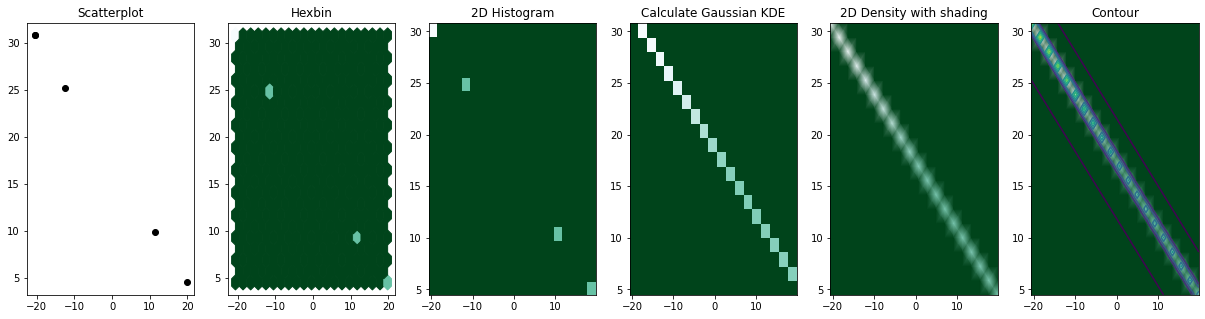

In [39]:
# create an xy density plot for eye movement probability
# collect data vectors
l_dx = all_sync_df.query("eye == 'L'")['dx']
l_dy = all_sync_df.query("eye == 'L'")['dy']
r_dx = all_sync_df.query("eye == 'R'")['dx']
r_dy = all_sync_df.query("eye == 'R'")['dy']

# simply plot these on a plane, right eye for example:
x,y = l_dx,l_dy
# Create a figure with 6 plot areas
fig, axes = plt.subplots(ncols=6, nrows=1, figsize=(21, 5))

# Everything starts with a Scatterplot
axes[0].set_title('Scatterplot')
axes[0].plot(x, y, 'ko')
# As you can see there is a lot of overlapping here!

# Thus we can cut the plotting window in several hexbins
nbins = 20
axes[1].set_title('Hexbin')
axes[1].hexbin(x, y, gridsize=nbins, cmap=plt.cm.BuGn_r)

# 2D Histogram
axes[2].set_title('2D Histogram')
axes[2].hist2d(x, y, bins=nbins, cmap=plt.cm.BuGn_r)

# Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
k = kde.gaussian_kde(np.array([l_dx,l_dy]).astype(np.float))
xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

# plot a density
axes[3].set_title('Calculate Gaussian KDE')
axes[3].pcolormesh(xi, yi, zi.reshape(xi.shape), shading='auto', cmap=plt.cm.BuGn_r)

# add shading
axes[4].set_title('2D Density with shading')
axes[4].pcolormesh(xi, yi, zi.reshape(xi.shape), shading='gouraud', cmap=plt.cm.BuGn_r)

# contour
axes[5].set_title('Contour')
axes[5].pcolormesh(xi, yi, zi.reshape(xi.shape), shading='gouraud', cmap=plt.cm.BuGn_r)
axes[5].contour(xi, yi, zi.reshape(xi.shape) )

1139
1139


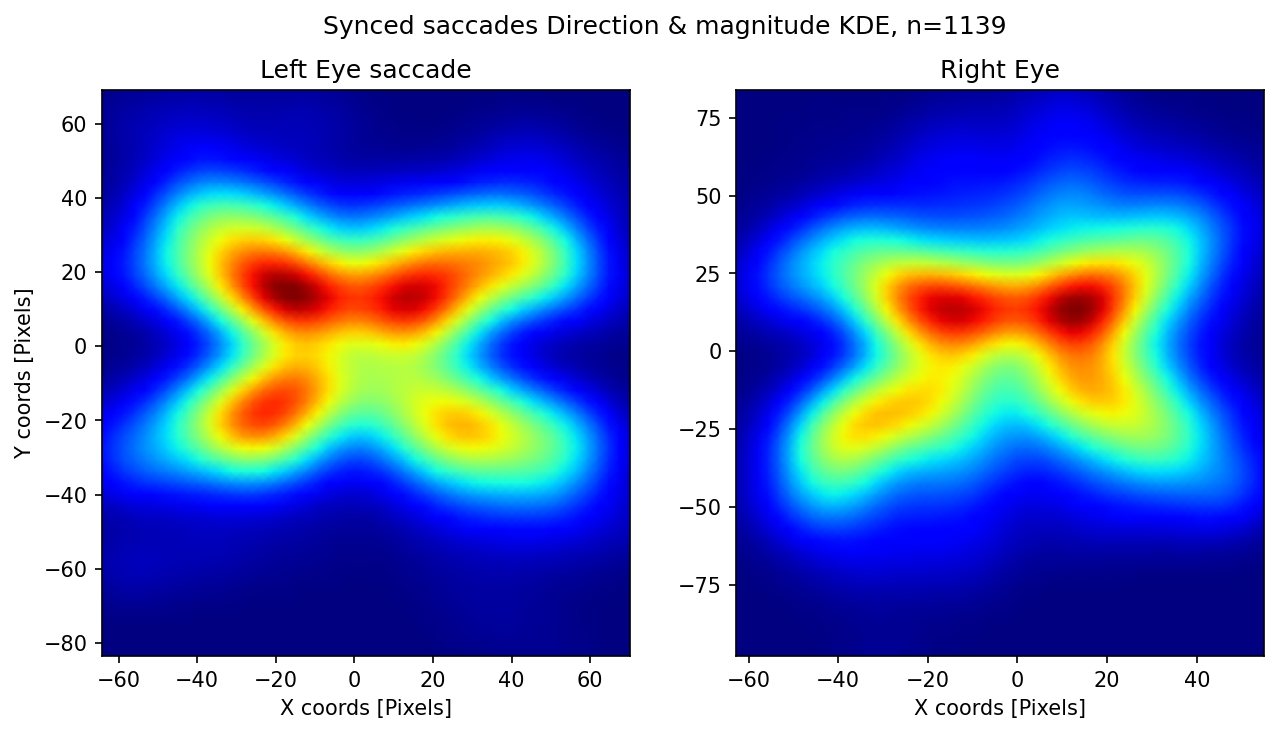

In [171]:
# create an xy density plot for eye movement probability
# collect data vectors

l_dx = all_sync_df.query("eye == 'L'")['dx']
l_dy = all_sync_df.query("eye == 'L'")['dy']
r_dx = all_sync_df.query("eye == 'R'")['dx']
r_dy = all_sync_df.query("eye == 'R'")['dy']


# evaluate a gaussian kde over a regular grid of nbinx x nbins over data extants
fig, axes = plt.subplots(ncols=2,figsize =(10,5),dpi=150)
nbins = 50
# left eye
x,y = l_dx,l_dy
print(len(x))
k = kde.gaussian_kde(np.array([x,y]).astype(np.float))
xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

axes[0].set_title('Left Eye saccade')
axes[0].pcolormesh(xi, yi, zi.reshape(xi.shape), shading='gouraud', cmap=plt.cm.jet)
axes[0].set_xlabel('X coords [Pixels]')
axes[0].set_ylabel('Y coords [Pixels]')
x,y = r_dx,r_dy
print(len(x))
k = kde.gaussian_kde(np.array([x,y]).astype(np.float))
xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
# contour
axes[1].set_title('Right Eye')
axes[1].pcolormesh(xi, yi, zi.reshape(xi.shape), shading='gouraud', cmap=plt.cm.jet)
axes[1].set_xlabel('X coords [Pixels]')

#axes[1].set_ylabel('Y coords [Pixels]')

fig.suptitle(f'Synced saccades Direction & magnitude KDE, n={len(x)}')
#plt.savefig(fname=r'D:\MarkS3\Pictures\Graphs\Synced_saccades_Direction_Magnitude_KDE_6_27_TAKE2.png')
#plt.colorbar(cax=axes[1])
#axes.contour(xi, yi, zi.reshape(xi.shape) )

Text(0.5, 0.98, 'Non-Synced saccades Direction & magnitude KDE, n_left=1317, n_right=969')

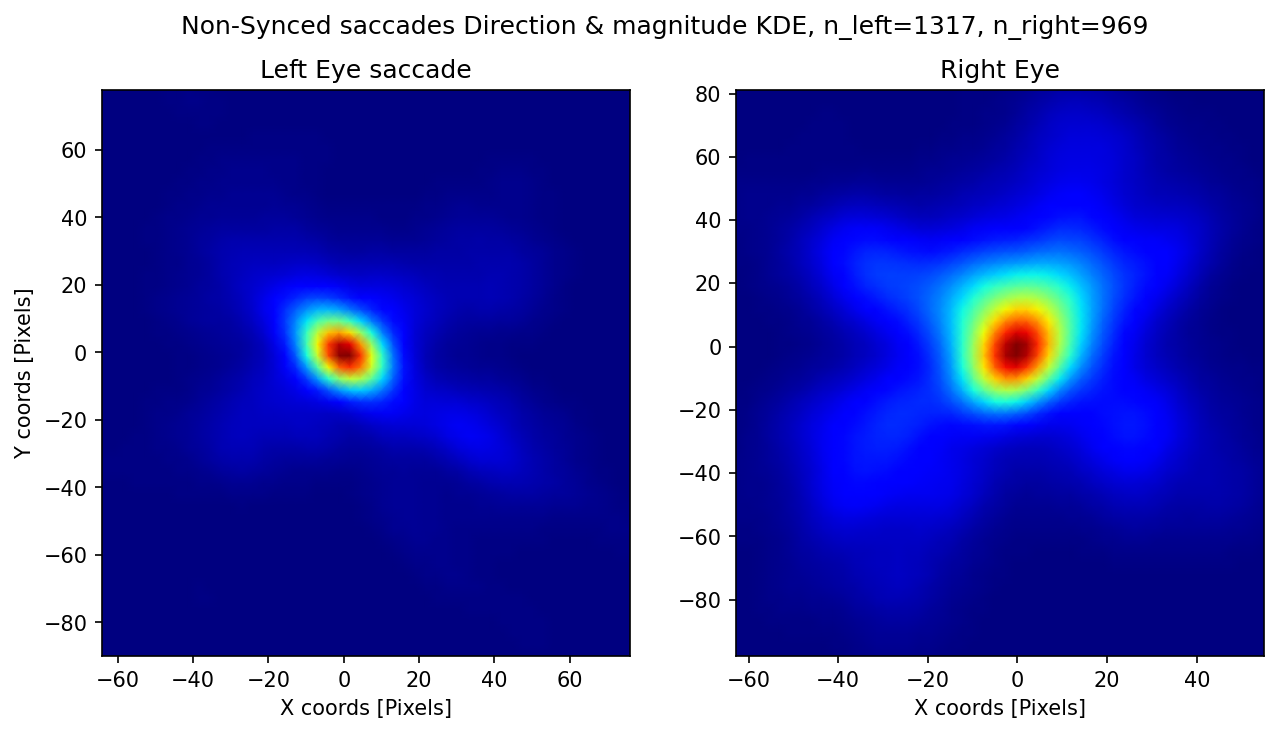

In [172]:
# Same thing but for non-synced saccades
# collect data vectors

l_dx = non_sync_df.query("eye == 'L'")['dx']
l_dy = non_sync_df.query("eye == 'L'")['dy']
r_dx = non_sync_df.query("eye == 'R'")['dx']
r_dy = non_sync_df.query("eye == 'R'")['dy']


# evaluate a gaussian kde over a regular grid of nbinx x nbins over data extants
fig, axes = plt.subplots(ncols=2,figsize =(10,5),dpi=150)
nbins = 50
# left eye
x,y = l_dx,l_dy
n_left = len(x)
k = kde.gaussian_kde(np.array([x,y]).astype(np.float))
xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

axes[0].set_title('Left Eye saccade')
axes[0].pcolormesh(xi, yi, zi.reshape(xi.shape), shading='gouraud', cmap=plt.cm.jet)
axes[0].set_xlabel('X coords [Pixels]')
axes[0].set_ylabel('Y coords [Pixels]')
x,y = r_dx,r_dy
n_right = len(x)
k = kde.gaussian_kde(np.array([x,y]).astype(np.float))
xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
# contour
axes[1].set_title('Right Eye')
axes[1].pcolormesh(xi, yi, zi.reshape(xi.shape), shading='gouraud', cmap=plt.cm.jet)
axes[1].set_xlabel('X coords [Pixels]')

#axes[1].set_ylabel('Y coords [Pixels]')

fig.suptitle(f'Non-Synced saccades Direction & magnitude KDE, n_left={n_left}, n_right={n_right}')
#plt.savefig(fname=r'D:\MarkS3\Pictures\Graphs\non_Synced_saccades_Direction_Magnitude_KDE_6_27.png')

In [137]:
def plot_kde(x,y,nbins,ax):
    k = kde.gaussian_kde(np.array([x,y]).astyp(np.float))
    xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
    zi = k(np.vstack([xi.flatten(), yi.flatten()]))
    ax.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='gouraud', cmap=plt.cm.jet)


In [176]:
np.array(x)

array([237.87256851, 246.31254753, 262.04803562, ..., 258.90418994,
       258.90418994, 249.79465028])

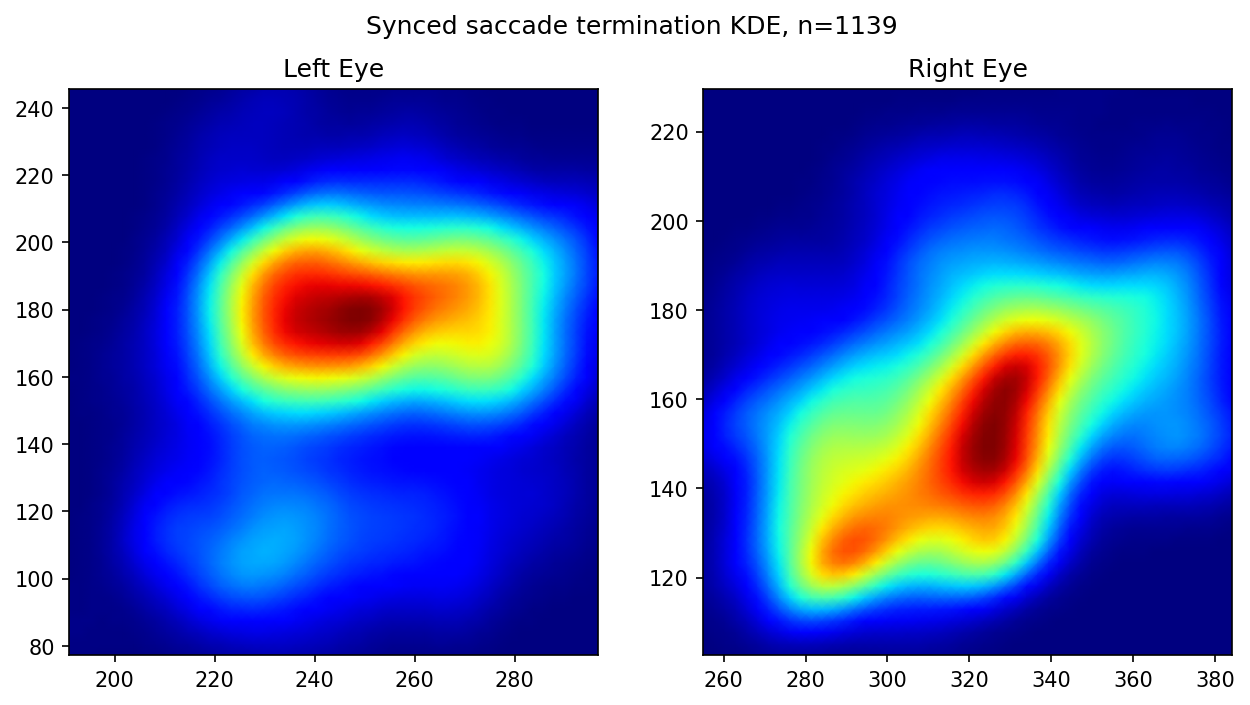

In [182]:
# create absolute XY density plot
# collect right and left eye absolute datapoints as done before
lx = all_sync_df.query("eye == 'L'")['x_coords'].values
ly = all_sync_df.query("eye == 'L'")['y_coords'].values
rx = all_sync_df.query("eye == 'R'")['x_coords'].values
ry = all_sync_df.query("eye == 'R'")['y_coords'].values

# create left eye plot:
xs_before = []
xs_after = []
ys_before = []
ys_after = []
for x_coords in lx:
    #print(x_coords)
    x_before, x_after, dx = saccade_before_after(x_coords)
    xs_before.append(x_before)
    xs_after.append(x_after)

for y_coords in ly:
    y_before, y_after, dy = saccade_before_after(y_coords)
    ys_before.append(y_before)
    ys_after.append(y_after)


# create saccade initiation heatmap:
x, y = np.array(xs_after), np.array(ys_after)
fig,axes = plt.subplots(ncols=2,figsize =(10,5),dpi=150)
plot_kde(x,y,50,ax=axes[0])
axes[0].set_title('Left Eye')

# re-initialize
xs_before = []
xs_after = []
ys_before = []
ys_after = []
# go over right eye
for x_coords in rx:
    #print(x_coords)
    x_before, x_after, dx = saccade_before_after(x_coords)
    xs_before.append(x_before)
    xs_after.append(x_after)

for y_coords in ry:
    y_before, y_after, dy = saccade_before_after(y_coords)
    ys_before.append(y_before)
    ys_after.append(y_after)
x, y = np.array(xs_after), np.array(ys_after)
plot_kde(x,y,50,ax=axes[1])
axes[1].set_title('Right Eye')
fig.suptitle(f'Synced saccade termination KDE, n={len(x)}')
#plt.savefig(fname=r'D:\MarkS3\Pictures\Graphs\Synced_saccades_termination_6_27.png')

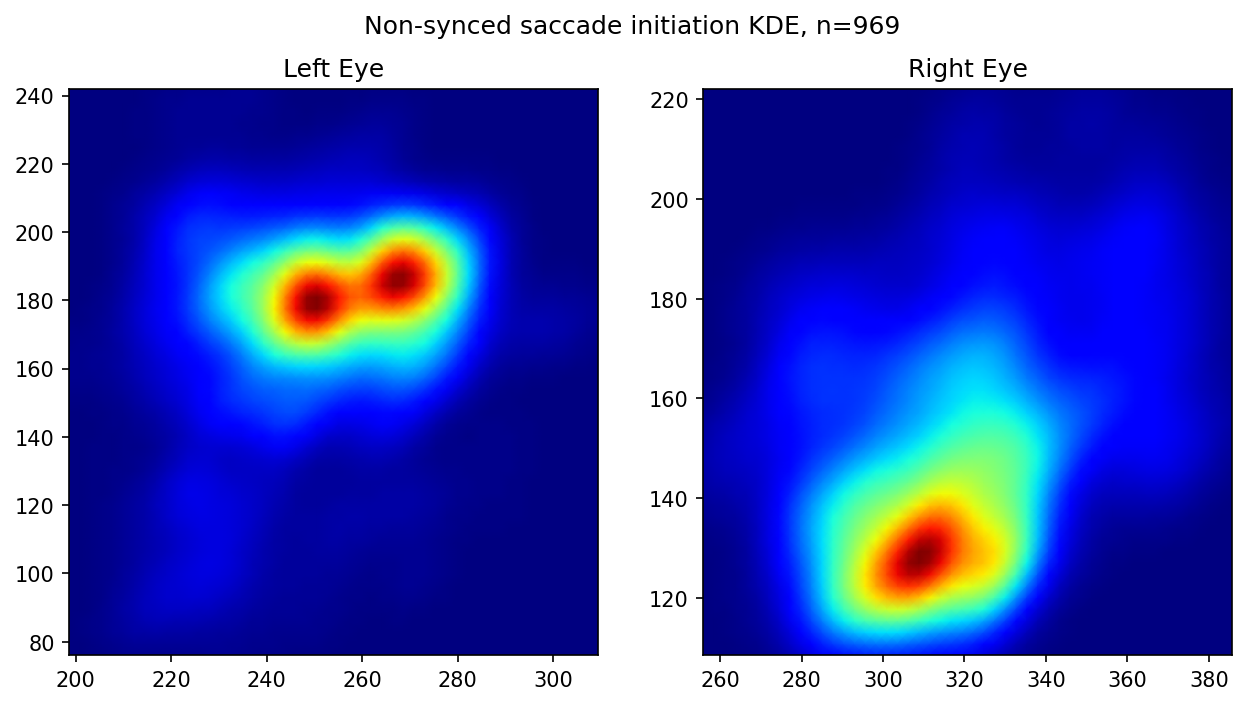

In [184]:
# create absolute XY density plot for non-synced saccades
# collect right and left eye absolute datapoints as done before
lx = non_sync_df.query("eye == 'L'")['x_coords'].values
ly = non_sync_df.query("eye == 'L'")['y_coords'].values
rx = non_sync_df.query("eye == 'R'")['x_coords'].values
ry = non_sync_df.query("eye == 'R'")['y_coords'].values

# create left eye plot:
xs_before = []
xs_after = []
ys_before = []
ys_after = []
for x_coords in lx:
    #print(x_coords)
    x_before, x_after, dx = saccade_before_after(x_coords)
    xs_before.append(x_before)
    xs_after.append(x_after)

for y_coords in ly:
    y_before, y_after, dy = saccade_before_after(y_coords)
    ys_before.append(y_before)
    ys_after.append(y_after)


# create saccade initiation heatmap:
x, y = np.array(xs_before), np.array(ys_before)
fig,axes = plt.subplots(ncols=2,figsize =(10,5),dpi=150)
plot_kde(x,y,50,ax=axes[0])
axes[0].set_title('Left Eye')

# re-initialize
xs_before = []
xs_after = []
ys_before = []
ys_after = []
# go over right eye
for x_coords in rx:
    #print(x_coords)
    x_before, x_after, dx = saccade_before_after(x_coords)
    xs_before.append(x_before)
    xs_after.append(x_after)

for y_coords in ry:
    y_before, y_after, dy = saccade_before_after(y_coords)
    ys_before.append(y_before)
    ys_after.append(y_after)
x, y = np.array(xs_before), np.array(ys_before)
plot_kde(x,y,50,ax=axes[1])
axes[1].set_title('Right Eye')
fig.suptitle(f'Non-synced saccade initiation KDE, n={len(x)}')
plt.savefig(fname=r'D:\MarkS3\Pictures\Graphs\Non-synced_saccades_initiation_6_27.png')

In [155]:
lx = all_sync_df.query("eye == 'L'")['x_coords'].values
lx[0]
#
# coords = x_coords
# max_ind = np.argmax(coords)
#
# min_ind = np.argmin(coords)
# min_ind
    # if max_ind < min_ind:
    #     before = coords[max_ind]
    #     after = coords[min_ind]
    # else:
    #     before = coords[min_ind]
    #     after = coords[max_ind]
    # delta = after-before
    # return before, after, delta

array([238.16842545, 238.18706842, 238.15648065, 238.19615444,
       238.16929515, 238.2413339 , 238.25121357, 238.19712857,
       238.22094762, 237.95080423, 237.96209503, 238.10352797,
       237.87256851, 238.12901635, 238.12574518, 237.97248381,
       238.17224783, 238.25917621, 238.13978978, 238.12531152,
       238.10579194, 238.2707461 , 238.21622449, 238.09988933,
       238.4054127 , 238.4054127 , 238.30499176, 238.11732211,
       238.19163337, 238.25474011, 238.2164939 , 238.18772242,
       238.26565361, 238.18178381, 238.11632328, 238.28106332,
       238.17300689, 238.09628077, 238.16252908, 238.14449722,
       238.35186044, 238.24864823, 238.35184754, 238.1842297 ,
       238.19703656, 238.36925191, 238.18460016, 238.22014382,
       238.14848391, 238.20273304, 238.31312862, 238.16278238,
       238.13004452, 237.91573481, 238.03029988, 238.20492694,
       237.98800289, 238.02368105, 238.14485431, 238.30453453,
       238.04718277, 238.11691554, 238.22595864, 238.30

In [150]:
lx[0].astyp(np.float)

AttributeError: 'str' object has no attribute 'astyp'

In [34]:
### WORKING ON SORTING INTO DF HERE ###
#dict_keys(['timestamps', 'fs', 'pxx', 'samples', 'x_coords', 'y_coords', 'vid_inds', 'x_speed', 'y_speed', 'magnitude', 'dx', 'dy', 'direction'])
# loop over all internal dictionaries and keys to create a dataframe

df = pd.DataFrame(columns=['block','eye','timestamps', 'fs', 'pxx', 'samples', 'x_coords', 'y_coords', 'vid_inds', 'x_speed', 'y_speed', 'magnitude', 'dx', 'dy', 'direction'])
d = all_sync_dict
index_counter = 0
for k in d.keys():
    block = d[k] # in a certain block
    for e in block.keys():
        eye = block[e] #in one of the eyes
        for row in range(len(eye['samples'])): # for each saccade
            for col in eye.keys(): # for each columm
                v = eye[col][row] # get value of location
                df.at[index_counter,'block'] = k
                df.at[index_counter,'eye'] = e
                df.at[index_counter,col] = v
            print(index_counter,end='\r',flush=True)
            index_counter +=1



In [16]:
for k in all_sync_dict.keys():
    sync_saccades = all_sync_dict[k]
    for e in ['L','R']:
        sync_saccades[e]['x_speed'] = []
        sync_saccades[e]['y_speed'] = []
        sync_saccades[e]['magnitude'] = []
        sync_saccades[e]['dx'] = [] # TEMP
        sync_saccades[e]['dy'] = [] # TEMP
        sync_saccades[e]['direction'] = []

        for s in range(len(sync_saccades[e]['timestamps'])):
            # speed:
            sync_saccades[e]['x_speed'].append(np.insert(np.diff(sync_saccades[e]['x_coords'][s]),0,float(0)))
            sync_saccades[e]['y_speed'].append(np.insert(np.diff(sync_saccades[e]['y_coords'][s]),0,float(0)))

            #Understand directionality and magnitude:
            # understand before and after
            x_before, x_after, dx = saccade_before_after(sync_saccades[e]['x_coords'][s])
            y_before, y_after, dy = saccade_before_after(sync_saccades[e]['y_coords'][s])

            # calculate magnitude (euclidean)
            s_mag = np.sqrt(dx**2 + dy**2)

            # get direction quadrant
            if dx > 0 and dy > 0:
                quad = 0
            elif dx < 0 < dy:
                quad = 1
            elif dx<0 and dy<0:
                quad = 2
            elif dx > 0 > dy:
                quad = 3
            # get direction (theta calculated from quadrent border)
            degrees_in_quadrent = np.rad2deg(np.arctan(np.abs(dy)/np.abs(dx)))
            theta = degrees_in_quadrent + (quad*90)

            # collect into dict
            sync_saccades[e]['dx'].append(dx)
            sync_saccades[e]['dy'].append(dy)
            sync_saccades[e]['magnitude'].append(s_mag)
            sync_saccades[e]['direction'].append(theta)
    all_sync_dict[k] = sync_saccades


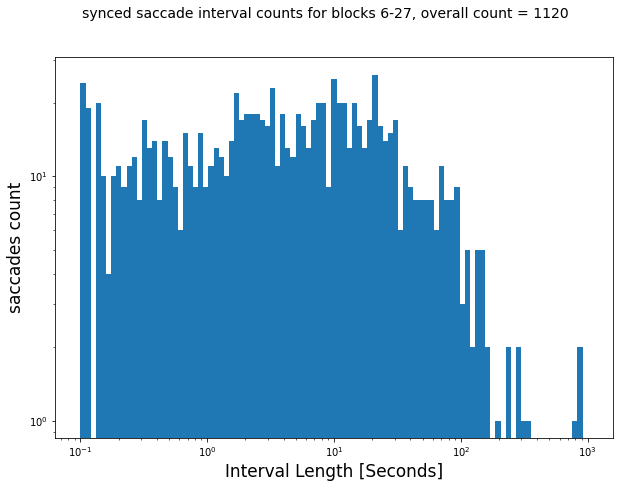

In [38]:
# create a count graph of saccade intervals
saccade_intervals = []
for k in all_sync_dict.keys():
    k_dict = all_sync_dict[k]['L'] # since i am only taking intervals from synced saccades the eye shouldn't matter
    k_intervals = np.diff(k_dict['timestamps'][:]) / block.sample_rate
    saccade_intervals.append(k_intervals)
all_intervals = np.hstack(saccade_intervals)

fig,ax = plt.subplots(figsize=(10,7))
ax.hist(all_intervals,bins=np.geomspace(0.1,1000,100),log=True,rwidth=1)
fig.suptitle(f'synced saccade interval counts for blocks 6-27, overall count = {len(all_intervals)}',fontsize=14)
ax.set_xlabel('Interval Length [Seconds]')
ax.set_xscale('log')
ax.set_ylabel('saccades count')
ax.xaxis.label.set_size(17)
ax.yaxis.label.set_size(17)
# save the figure
#plt.savefig(fname=r'D:\MarkS3\Pictures\Graphs\synced_saccade_interval_counts_for_blocks_6_27.png')

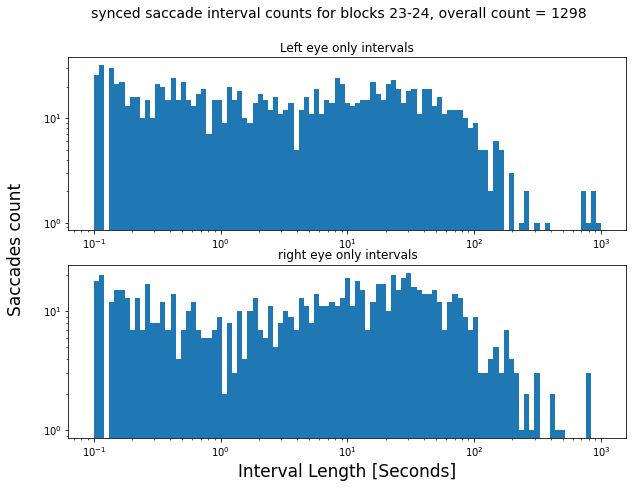

In [47]:
# create a count graph of saccade intervals
l_saccade_intervals = []
r_saccade_intervals = []
for k in non_sync_dict.keys():

    k_dict = non_sync_dict[k]
    l_intervals = np.diff(k_dict['L']['timestamps'][:]) / block.sample_rate
    r_intervals = np.diff(k_dict['R']['timestamps'][:]) / block.sample_rate
    l_saccade_intervals.append(l_intervals)
    r_saccade_intervals.append(r_intervals)
all_l_intervals = np.hstack(l_saccade_intervals)
all_r_intervals = np.hstack(r_saccade_intervals)

fig,axes = plt.subplots(2,figsize=(10,7))
titles = ['Left eye only intervals','right eye only intervals']
for i,eye_intervals in enumerate([all_l_intervals,all_r_intervals]):
    ax = axes[i]
    ax.hist(eye_intervals,bins=np.geomspace(0.1,1000,100),log=True,rwidth=1)
    ax.set_title(titles[i])
    ax.set_xscale('log')

fig.suptitle(f'synced saccade interval counts for blocks 23-24, overall count = {len(all_l_intervals)}',fontsize=14)
ax.set_xlabel('Interval Length [Seconds]')

fig.text(0.04, 0.5, 'Saccades count', va='center', rotation='vertical',fontsize=17)
ax.xaxis.label.set_size(17)
ax.yaxis.label.set_size(17)
# save the figure
#plt.savefig(fname=r'D:\MarkS3\Pictures\Graphs\non_sync_saccade_interval_counts_for_blocks_6_27.png')

In [52]:
##### DEAL WITH BAD SPEED VALUES
# create an LFP graph like before with only clean samples and speed appended to the seconds timebase
# start by stacking everything up
lx_speed_stack = []
ly_speed_stack = []
rx_speed_stack = []
ry_speed_stack = []
lfp_stack = []
l_non_sync = []
r_non_sync = []
for k in all_sync_dict.keys():
    k_dict = all_sync_dict[k]
    stack = np.vstack(k_dict['L']['samples'][:]) # the eye doesn't matter as we've already established that these are synced
    lfp_stack.append(stack)
    lx_speed_stack.append(k_dict['L']['x_speed'])
    ly_speed_stack.append(k_dict['L']['y_speed'])
    rx_speed_stack.append(k_dict['R']['x_speed'])
    ry_speed_stack.append(k_dict['R']['y_speed'])

for k in non_sync_dict.keys():

    k_dict = non_sync_dict[k]
    l_stack = np.vstack(k_dict['L']['samples'][:])
    r_stack = np.vstack(k_dict['R']['samples'][:])
    l_non_sync.append(l_stack)
    r_non_sync.append(r_stack)

all_saccade_stack = np.vstack(lfp_stack)
l_non_sync_stack = np.vstack(l_non_sync)
r_non_sync_stack = np.vstack(r_non_sync)
all_lx_speed = np.vstack(lx_speed_stack)
all_rx_speed = np.vstack(rx_speed_stack)
all_ly_speed = np.vstack(ly_speed_stack)
all_ry_speed = np.vstack(ry_speed_stack)


ValueError: need at least one array to concatenate

In [31]:
# Organize and employ a threshold on the all_saccade_stack
clean_stack = []
noise_stack = []
lx_clean_speed_stack = []
ly_clean_speed_stack = []
rx_clean_speed_stack = []
ry_clean_speed_stack = []

# sift out noisy responses based on amplitude
for i in range(np.shape(all_saccade_stack)[0]):
    if np.max(all_saccade_stack[i]) < 400 and np.min(all_saccade_stack[i]) > -400:
        clean_stack.append(all_saccade_stack[i])
        lx_clean_speed_stack.append(all_lx_speed[i])
        rx_clean_speed_stack.append(all_rx_speed[i])
        ly_clean_speed_stack.append(all_ly_speed[i])
        ry_clean_speed_stack.append(all_ry_speed[i])
    else:
        noise_stack.append(all_saccade_stack[i])

mean_samples_vector_all = np.mean(all_saccade_stack,axis=0)
mean_samples_vector_dirty = np.mean(noise_stack,axis=0)
mean_samples_vector_clean = np.mean(clean_stack,axis=0)

# correct the x axis for samples
x_axis = (np.array(range(len(mean_samples_vector_clean))) / 20000) - 2

# deal with speed vectors:
lx_mean_speed_vec = np.mean(lx_clean_speed_stack,axis=0)
rx_mean_speed_vec = np.mean(rx_clean_speed_stack,axis=0)
ry_mean_speed_vec = np.mean(ry_clean_speed_stack,axis=0)
ly_mean_speed_vec = np.mean(ly_clean_speed_stack,axis=0)

speed_x_axis = (np.linspace(0,len(mean_samples_vector_clean),len(rx_mean_speed_vec)) / 20000) - 2


In [32]:
# now sort the non-synced saccades
l_clean_stack = []
r_clean_stack = []

for i in range(np.shape(l_non_sync_stack)[0]):
    if np.max(l_non_sync_stack[i]) < 400 and np.min(l_non_sync_stack[i]) > -400:
        l_clean_stack.append(l_non_sync_stack[i])

for i in range(np.shape(r_non_sync_stack)[0]):
    if np.max(r_non_sync_stack[i]) < 400 and np.min(r_non_sync_stack[i]) > -400:
        r_clean_stack.append(r_non_sync_stack[i])

r_mean_samples_vector = np.mean(r_clean_stack,axis=0)
l_mean_samples_vector = np.mean(l_clean_stack,axis=0)

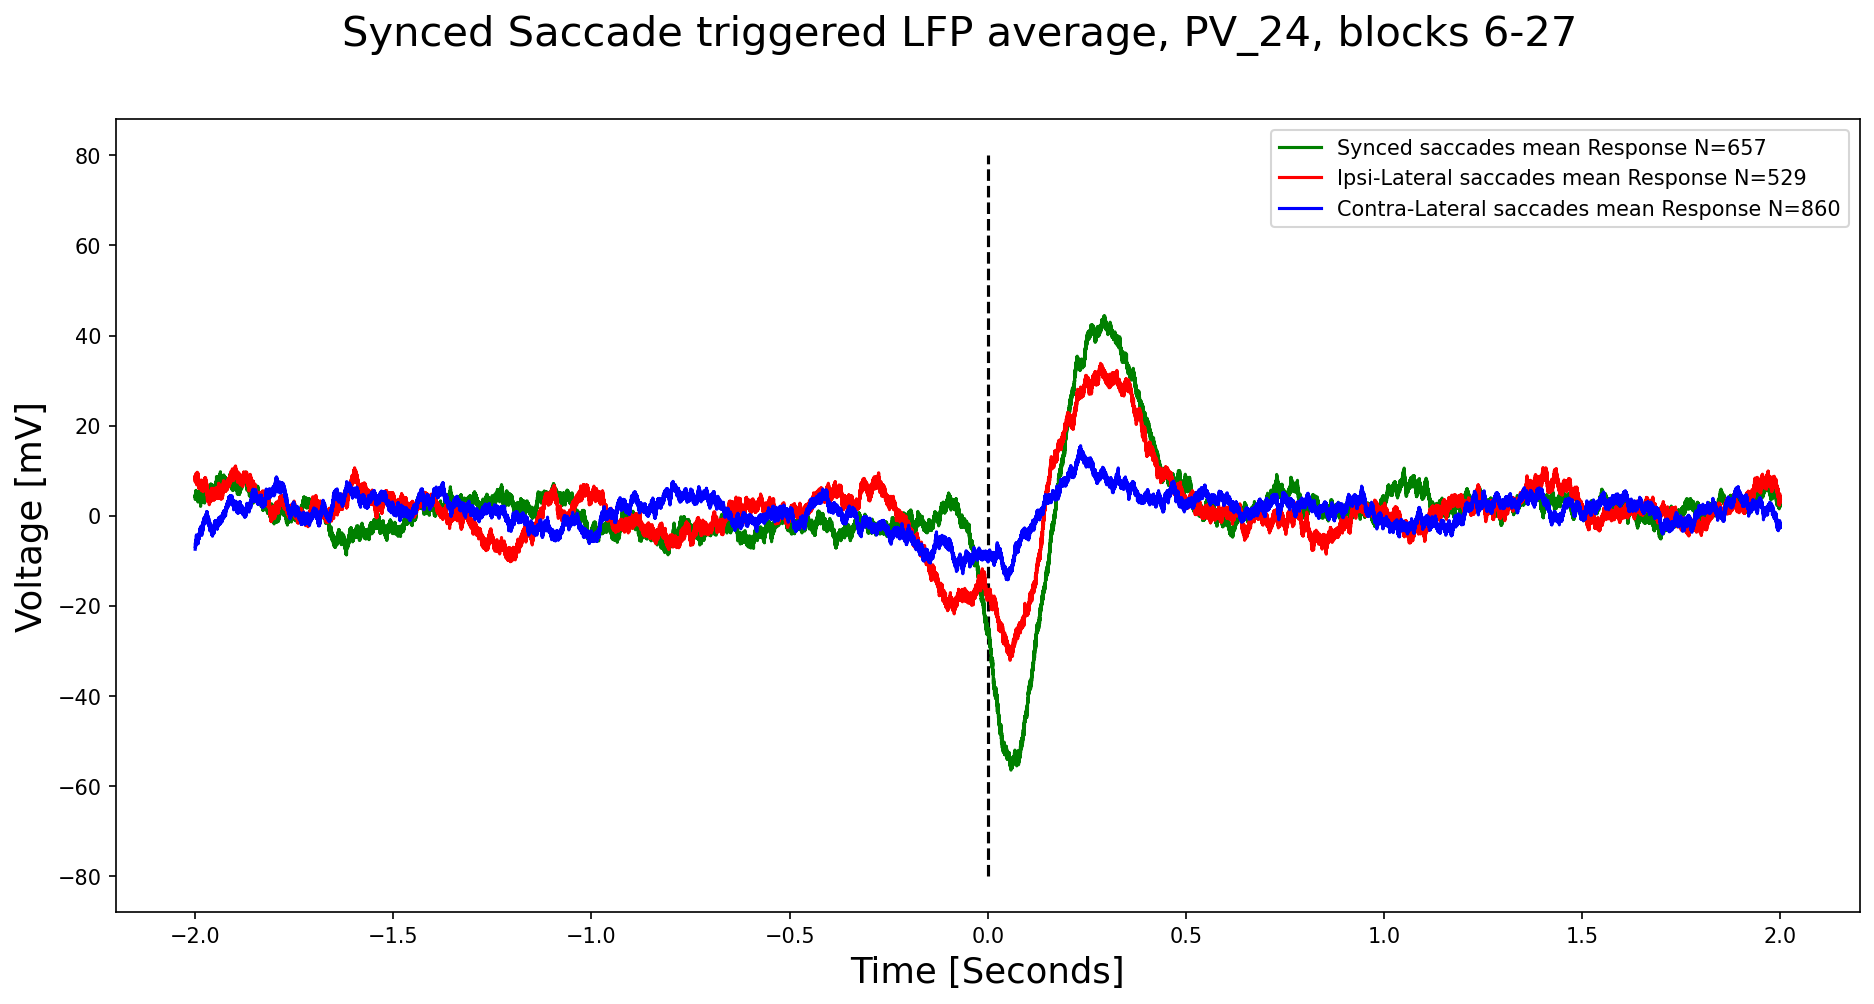

In [37]:
# this is the plotting step:
fig,axes = plt.subplots(dpi=150,figsize=(15,7))
#
# for i in tqdm(range(np.shape(clean_stack)[0])):
#     # plot the clean responses
#     axes.plot(x_axis,clean_stack[i],alpha=0.0025, color='green')
#     # plot the zero line

axes.vlines(0,-80,80,linestyles='--')
#axes.plot(x_axis,mean_samples_vector_all,color='blue',label=f'all Mean Response N={np.shape(all_saccade_stack)[0]}')
#axes.plot(x_axis,mean_samples_vector_dirty,color='red',label=f'dirty Mean Response N={np.shape(noise_stack)[0]}')
axes.plot(x_axis,mean_samples_vector_clean,color='green',label=f'Synced saccades mean Response N={np.shape(clean_stack)[0]}')
axes.plot(x_axis,r_mean_samples_vector,color='red',label=f'Ipsi-Lateral saccades mean Response N={np.shape(r_clean_stack)[0]}')
axes.plot(x_axis,l_mean_samples_vector,color='blue',label=f'Contra-Lateral saccades mean Response N={np.shape(l_clean_stack)[0]}')
# axes.plot(speed_x_axis,(lx_mean_speed_vec*20)-80,color='red',label='mean left eye x speed')
# axes.plot(speed_x_axis,(ly_mean_speed_vec*20)-80,color='orange',label='mean left eye y speed')
# axes.plot(x_axis,mean_samples_vector_all,color='green')
axes.set_xlabel('Time [Seconds]')
axes.set_ylabel('Voltage [mV]')
axes.xaxis.label.set_size(17)
axes.yaxis.label.set_size(17)
plt.suptitle('Synced Saccade triggered LFP average, PV_24, blocks 6-27',fontsize=20)
plt.legend()
#plt.savefig(fname=r'D:\MarkS3\Pictures\Graphs\Saccade_triggered_LFP_average_PV_24_blocks 6-27')

In [63]:
# export the lfp stack for matlab analysis:
export_dict = {
    'mean_clean_vec':mean_samples_vector_clean,
    'lfp_clean_stack':clean_stack
}
scipy.io.savemat(file_name=r'D:\EEGLAB\lfp_exports_blocks_6_27_clean.mat',mdict=export_dict)

In [236]:
# Now that I have a LR divided dict for each block I should go over them and collect the appropriate saccades
# but first I should see which saccades are actually the same (LR in sync)
# sort synced and un-synced saccades
sync_saccades, non_sync_saccades = sort_synced_saccades(saccade_dict['023'])

# I should now enrich each saccade with speed, real magnitude and direction so I can create my plots
#collect speeds, magnitude and direction for each saccade:

for e in ['L','R']:
    sync_saccades[e]['x_speed'] = []
    sync_saccades[e]['y_speed'] = []
    sync_saccades[e]['magnitude'] = []
    sync_saccades[e]['dx'] = [] # TEMP
    sync_saccades[e]['dy'] = [] # TEMP
    sync_saccades[e]['direction'] = []

    for s in range(len(sync_saccades[e]['timestamps'])):
        # speed:
        sync_saccades[e]['x_speed'].append(np.insert(np.diff(sync_saccades[e]['x_coords'][s]),0,float(0)))
        sync_saccades[e]['y_speed'].append(np.insert(np.diff(sync_saccades[e]['y_coords'][s]),0,float(0)))

        #Understand directionality and magnitude:
        # understand before and after
        x_before, x_after, dx = saccade_before_after(sync_saccades[e]['x_coords'][s])
        y_before, y_after, dy = saccade_before_after(sync_saccades[e]['y_coords'][s])

        # calculate magnitude (euclidean)
        s_mag = np.sqrt(dx**2 + dy**2)

        # get direction quadrant
        if dx > 0 and dy > 0:
            quad = 0
        elif dx < 0 < dy:
            quad = 1
        elif dx<0 and dy<0:
            quad = 2
        elif dx > 0 > dy:
            quad = 3
        # get direction (theta calculated from quadrent border)
        degrees_in_quadrent = np.rad2deg(np.arctan(np.abs(dy)/np.abs(dx)))
        theta = degrees_in_quadrent + (quad*90)

        # collect into dict
        sync_saccades[e]['dx'].append(dx)
        sync_saccades[e]['dy'].append(dy)
        sync_saccades[e]['magnitude'].append(s_mag)
        sync_saccades[e]['direction'].append(theta)


<ipython-input-281-f360237c057e>:13: UserWarning: The following kwargs were not used by contour: 'colormap', 'heatmap'
  ax.contour(mag_mesh,theta_mesh,Z,colormap='jet',heatmap=True)
No handles with labels found to put in legend.


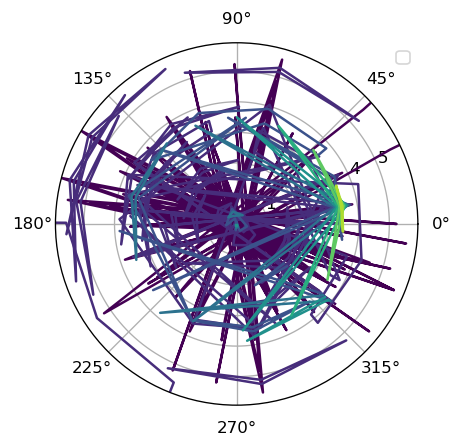

In [281]:
# create a left-eye polar plot
# this basically means a histogram of specific contours in the polar coordinates plane - which means we want to span it:


thetas = sync_saccades['L']['direction']
magnitudes = sync_saccades['L']['magnitude']
mag_bins = np.arange(0,np.max(magnitudes),3) #pixels
theta_bins = np.deg2rad(np.arange(0,360,20)) #radians
mag_mesh, theta_mesh = np.meshgrid(mag_bins,theta_bins)
fig,ax = plt.subplots(dpi=120,subplot_kw=dict(projection='polar'))
# populate Z
Z, xedges, yedges = np.histogram2d(np.deg2rad(thetas),magnitudes,bins=[np.shape(mag_mesh)[0],np.shape(mag_mesh)[1]])
ax.contour(mag_mesh,theta_mesh,Z,colormap='jet',heatmap=True)
ax.legend()
# OKAY I don't get it - need to ask for help

In [56]:
#The polar plot just did not work out - going histogram
# collect the saccades direction from all blocks:
l_directions = []
r_directions = []
l_magnitudes = []
r_magnitudes = []
for k in all_sync_dict.keys():
    k_dict = all_sync_dict[k]
    l_directions.append(k_dict['L']['direction'])
    r_directions.append(k_dict['R']['direction'])
    l_magnitudes.append(k_dict['L']['magnitude'])
    r_magnitudes.append(k_dict['R']['magnitude'])
# l_theta = np.vstack(l_directions)
# l_mags = np.vstack(l_magnitudes)
# r_theta = np.vstack(r_directions)
# r_mags = np.vstack(r_magnitudes)

#
# fig, ax = plt.subplots(dpi=200,subplot_kw=dict(projection='polar'))
# plt.hist(np.deg2rad(l_theta))

np.shape(l_directions)

c:\users\marks3\pycharmprojects\pythonproject3\venv\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


(19,)

In [10]:
k_dict = saccade_dict['023']
#fig,ax = plt.subplots(figsize=(10,6))

speed_dict = {
    'l_speed':[],
    'l_inds':[],
    'r_speed':[],
    'r_inds':[]
}

for i in range(len(k_dict['timestamps'])):
    lx_speed = np.insert(np.diff(k_dict['lx_coords'][i]),0,float(0))
    ly_speed = np.insert(np.diff(k_dict['ly_coords'][i]),0,float(0))
    l_inds = k_dict['l_vid_inds'][i]
    l_speed = np.abs(lx_speed) + np.abs(ly_speed)

    rx_speed = np.insert(np.diff(k_dict['rx_coords'][i]),0,float(0))
    ry_speed = np.insert(np.diff(k_dict['ry_coords'][i]),0,float(0))
    r_inds = k_dict['r_vid_inds'][i]
    r_speed = np.abs(rx_speed) + np.abs(ry_speed)

    speed_dict['l_speed'].append(l_speed)
    speed_dict['r_speed'].append(r_speed)
    speed_dict['l_inds'].append(l_inds)
    speed_dict['r_inds'].append(r_inds)

    #ax.plot(range(len(k_dict['samples'][0])),k_dict['samples'][0])
    #ax.plot(l_inds,l_speed,alpha=0.5,color='green')
    #ax.plot(r_inds,r_speed,alpha=0.5,color='red')


In [14]:
# stack everything up (whole saccade version) V1

speed_list = []
loc_list = []
samples_stack = []
for k in saccade_dict.keys():
    k_dict = saccade_dict[k]
    speed_dict = {
        'l_speed':[],
        'l_inds':[],
        'r_speed':[],
        'r_inds':[]
    }
    loc_dict = {
        "delta_rx":[],
        "delta_ry":[],
        "delta_lx":[],
        "delta_ly":[]
    }
    #iterate over the saccades
    for i in range(len(k_dict['timestamps'])):

        # left eye speeds
        lx_speed = np.insert(np.diff(k_dict['lx_coords'][i]),0,float(0))
        ly_speed = np.insert(np.diff(k_dict['ly_coords'][i]),0,float(0))
        l_inds = k_dict['l_vid_inds'][i]
        l_speed = np.abs(lx_speed) + np.abs(ly_speed)

        # right eye speeds
        rx_speed = np.insert(np.diff(k_dict['rx_coords'][i]),0,float(0))
        ry_speed = np.insert(np.diff(k_dict['ry_coords'][i]),0,float(0))
        r_inds = k_dict['r_vid_inds'][i]
        r_speed = np.abs(rx_speed) + np.abs(ry_speed)

        # append to the speed dict
        speed_dict['l_speed'].append(l_speed)
        speed_dict['r_speed'].append(r_speed)
        speed_dict['l_inds'].append(l_inds)
        speed_dict['r_inds'].append(r_inds)

        # deal with the location deltas
        # left eye
        lx_coords = k_dict['lx_coords'][i][~np.isnan(k_dict['lx_coords'][i])]

        lx_start_point = lx_coords[0]
        lx_end_point = lx_coords[-1]
        lx_delta = lx_end_point - lx_start_point
        ly_coords = k_dict['ly_coords'][i][~np.isnan(k_dict['ly_coords'][i])]
        ly_start_point = ly_coords[0]
        ly_end_point = ly_coords[-1]
        ly_delta = ly_end_point - ly_start_point
        # right eye
        rx_coords = k_dict['rx_coords'][i][~np.isnan(k_dict['rx_coords'][i])]
        rx_start_point =rx_coords[0]
        rx_end_point = rx_coords[-1]
        rx_delta = rx_end_point - rx_start_point
        ry_coords = k_dict['ry_coords'][i][~np.isnan(k_dict['ry_coords'][i])]
        ry_start_point = ry_coords[0]
        ry_end_point = ry_coords[-1]
        ry_delta = ry_end_point - ry_start_point
        # append to dict
        loc_dict["delta_rx"].append(rx_delta)
        loc_dict["delta_ry"].append(ry_delta)
        loc_dict["delta_lx"].append(lx_delta)
        loc_dict["delta_ly"].append(ly_delta)

    speed_list.append(speed_dict)
    loc_list.append(loc_dict)

    samples_stack.append(np.vstack(k_dict["samples"][:]))

all_samples_stack = np.vstack(samples_stack)
mean_response = np.mean(all_samples_stack,axis=0)
# this version has a problem with all nan saccades and iterates with many repeating lines - try and make it better

IndexError: index 0 is out of bounds for axis 0 with size 0

In [331]:
# stack everything up (whole saccade version) V2

speed_list = []
loc_list = []
samples_stack = []
for k in saccade_dict.keys():
    k_dict = saccade_dict[k]
    speed_dict = {
        'l_speed':[],
        'l_inds':[],
        'r_speed':[],
        'r_inds':[]
    }
    loc_dict = {
        "delta_rx":[],
        "delta_ry":[],
        "delta_lx":[],
        "delta_ly":[]
    }
    #iterate over the saccades
    for i in range(len(k_dict['timestamps'])):

        # left eye speeds
        lx_speed = np.insert(np.diff(k_dict['lx_coords'][i]),0,float(0))
        ly_speed = np.insert(np.diff(k_dict['ly_coords'][i]),0,float(0))
        l_inds = k_dict['l_vid_inds'][i]
        l_speed = np.abs(lx_speed) + np.abs(ly_speed)

        # right eye speeds
        rx_speed = np.insert(np.diff(k_dict['rx_coords'][i]),0,float(0))
        ry_speed = np.insert(np.diff(k_dict['ry_coords'][i]),0,float(0))
        r_inds = k_dict['r_vid_inds'][i]
        r_speed = np.abs(rx_speed) + np.abs(ry_speed)

        # append to the speed dict
        speed_dict['l_speed'].append(l_speed)
        speed_dict['r_speed'].append(r_speed)
        speed_dict['l_inds'].append(l_inds)
        speed_dict['r_inds'].append(r_inds)

        # deal with the location deltas
        # left eye
        lx_coords = k_dict['lx_coords'][i][~np.isnan(k_dict['lx_coords'][i])]

        lx_start_point = lx_coords[0]
        lx_end_point = lx_coords[-1]
        lx_delta = lx_end_point - lx_start_point
        ly_coords = k_dict['ly_coords'][i][~np.isnan(k_dict['ly_coords'][i])]
        ly_start_point = ly_coords[0]
        ly_end_point = ly_coords[-1]
        ly_delta = ly_end_point - ly_start_point
        # right eye
        rx_coords = k_dict['rx_coords'][i][~np.isnan(k_dict['rx_coords'][i])]
        rx_start_point =rx_coords[0]
        rx_end_point = rx_coords[-1]
        rx_delta = rx_end_point - rx_start_point
        ry_coords = k_dict['ry_coords'][i][~np.isnan(k_dict['ry_coords'][i])]
        ry_start_point = ry_coords[0]
        ry_end_point = ry_coords[-1]
        ry_delta = ry_end_point - ry_start_point
        # append to dict
        loc_dict["delta_rx"].append(rx_delta)
        loc_dict["delta_ry"].append(ry_delta)
        loc_dict["delta_lx"].append(lx_delta)
        loc_dict["delta_ly"].append(ly_delta)

    speed_list.append(speed_dict)
    loc_list.append(loc_dict)

    samples_stack.append(np.vstack(k_dict["samples"][:]))

all_samples_stack = np.vstack(samples_stack)
mean_response = np.mean(all_samples_stack,axis=0)


[{'delta_rx': [-25.679986602639133,
   19.56053350167707,
   20.006490224135348,
   -5.039895033173252,
   -4.913049703019681,
   8.224940893286771,
   8.306210079185803,
   -0.42176135115522584,
   -0.42779778807982893,
   0.8777810866566824],
  'delta_ry': [-17.245879412388973,
   27.73402748623002,
   27.767402527082595,
   -18.20653632540109,
   -18.24740801409547,
   33.06188958905196,
   32.634647507378276,
   1.100211942517177,
   0.9022821774496208,
   -7.900270019851092],
  'delta_lx': [-3.5485925943379186,
   -1.9518396271893437,
   -2.010726440310691,
   6.956299139232925,
   6.868552961311963,
   -4.7414925302499,
   -4.878738450159659,
   11.35000326376553,
   11.630605182380634,
   -11.74698064703827],
  'delta_ly': [-1.3467546206083227,
   1.7459183888645953,
   1.718000163291208,
   16.816146161071103,
   16.851422931962603,
   -9.235384677185635,
   -9.427537153974015,
   -1.9411664195357332,
   -1.9180933910639055,
   36.74969183527071]},
 {'delta_rx': [22.53193830659

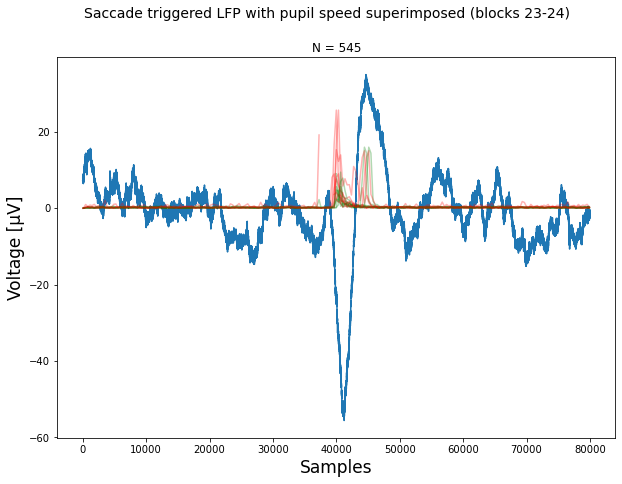

In [282]:
fig, ax = plt.subplots(figsize=(10,7))
ax.plot(range(len(mean_response)),mean_response)
for i in range(len(speed_list)):
    sd = speed_list[i]
    for x in range(len(sd)):
        ax.plot(sd['l_inds'][x],sd['l_speed'][x],color='green',alpha=0.3)
        ax.plot(sd['r_inds'][x],sd['r_speed'][x],color='red',alpha=0.3)

ax.set_xlabel('Samples')

ax.set_ylabel('Voltage [\u03BCV]')
ax.xaxis.label.set_size(17)
ax.yaxis.label.set_size(17)
plt.suptitle('Saccade triggered LFP with pupil speed superimposed (blocks 23-24)',fontsize=14)
plt.title(f'N = {np.shape(all_samples_stack)[0]}')
plt.savefig(fname=r'D:\MarkS3\Pictures\Graphs\saccade_triggered_lfpWith_eye_movements.png')

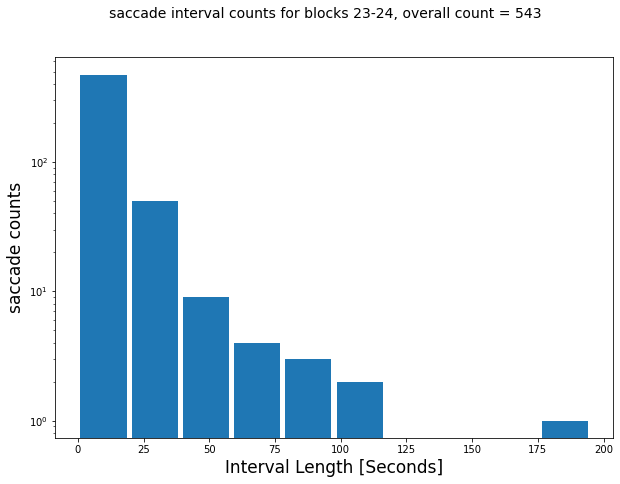

In [302]:
# create a count graph of saccade intervals
saccade_intervals = []
for k in saccade_dict.keys():
    k_dict = saccade_dict[k]
    k_intervals = np.diff(k_dict['timestamps'][:]) / block.sample_rate
    saccade_intervals.append(k_intervals)
all_intervals = np.hstack(saccade_intervals)

fig,ax = plt.subplots(figsize=(10,7))
ax.hist(all_intervals,log=True,rwidth=0.9)
fig.suptitle(f'saccade interval counts for blocks 23-24, overall count = {len(all_intervals)}',fontsize=14)
ax.set_xlabel('Interval Length [Seconds]')
ax.set_ylabel('saccade counts')
ax.xaxis.label.set_size(17)
ax.yaxis.label.set_size(17)
plt.savefig(fname=r'D:\MarkS3\Pictures\Graphs\saccade_interval_histogram_23-24.png')

In [147]:
# stack everything up (pre-post version)
blocklist_stack = []
for k in saccade_dict.keys():
    pre_dict = saccade_dict[k][0]
    post_dict = saccade_dict[k][1]
    pre_stack = np.vstack(pre_dict["samples"][:])
    post_stack = np.vstack(post_dict["samples"][:])
    long_stack = np.hstack((pre_stack, post_stack))
    blocklist_stack.append(long_stack)
all_saccade_stack = np.vstack(blocklist_stack)


In [28]:
# Organize and plot the mean_psd of all saccades:
pre_psd_stack = []
post_psd_stack = []
for k in saccade_dict.keys():
    pre_dict = saccade_dict[k][0]
    post_dict = saccade_dict[k][1]
    pre_stack = np.vstack(pre_dict['pxx'][:])
    post_stack = np.vstack(post_dict['pxx'][:])
    pre_psd_stack.append(pre_stack)
    post_psd_stack.append(post_stack)


all_pre_stack_psd = np.vstack(pre_psd_stack)
all_post_stack_psd = np.vstack(post_psd_stack)
fs_axis = saccade_dict[list(saccade_dict.keys())[0]][0]['fs'][0]

Text(0, 0.5, 'PSD')

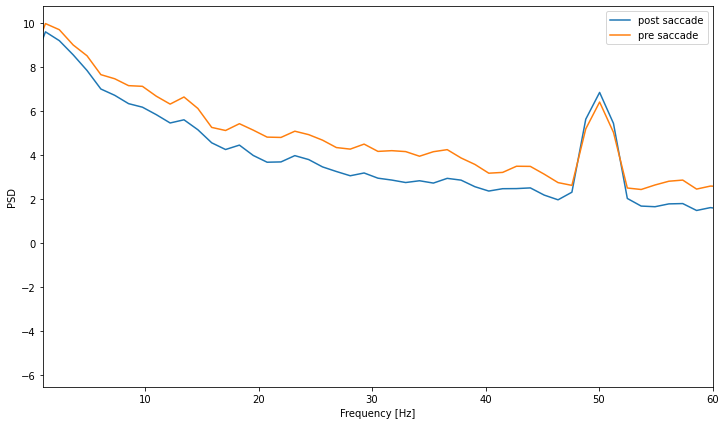

In [29]:
mean_pre_psd = np.mean(all_pre_stack_psd,axis=0)
mean_post_psd = np.mean(all_post_stack_psd,axis=0)
fig, axes = plt.subplots(figsize=(12,7))
axes.plot(fs_axis,np.log(mean_post_psd),label='post saccade')
axes.plot(fs_axis,np.log(mean_pre_psd),label='pre saccade')
axes.set_xlim(1,60)
plt.legend()
axes.set_xlabel('Frequency [Hz]')
axes.set_ylabel('PSD')

In [ ]:
# Organize and employ a threshold on the all_saccade_stack
clean_stack = []
noise_stack = []

# sift out noisy responses based on amplitude
for i in range(np.shape(all_saccade_stack)[0]):
    if np.max(all_saccade_stack[i]) < 400 and np.min(all_saccade_stack[i]) > -400:
        clean_stack.append(all_saccade_stack[i])
    else:
        noise_stack.append(all_saccade_stack[i])
mean_samples_vector_all = np.mean(all_saccade_stack,axis=0)
mean_samples_vector_dirty = np.mean(noise_stack,axis=0)
mean_samples_vector_clean = np.mean(clean_stack,axis=0)
x_axis = (np.array(range(len(mean_samples_vector_clean))) / 20000) - 2


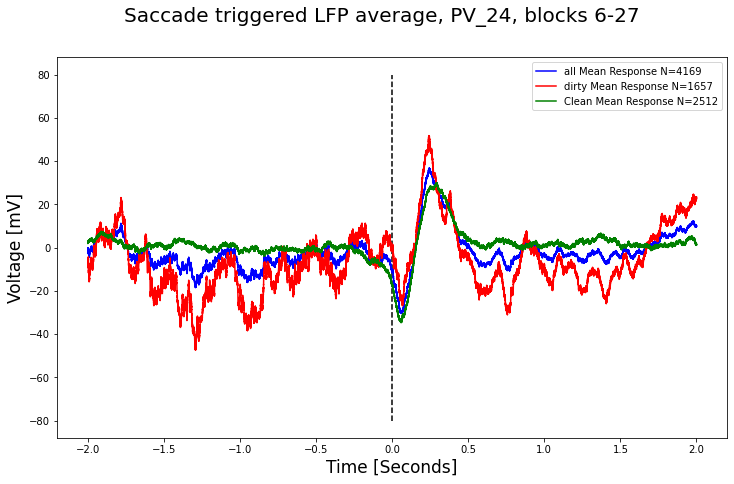

In [54]:
# this is the plotting step:
fig,axes = plt.subplots(figsize=(12,7))
#
# for i in tqdm(range(np.shape(clean_stack)[0])):
#     # plot the clean responses
#     axes.plot(x_axis,clean_stack[i],alpha=0.0025, color='green')
#     # plot the zero line

axes.vlines(0,-80,80,linestyles='--')
axes.plot(x_axis,mean_samples_vector_all,color='blue',label=f'all Mean Response N={np.shape(all_saccade_stack)[0]}')
axes.plot(x_axis,mean_samples_vector_dirty,color='red',label=f'dirty Mean Response N={np.shape(noise_stack)[0]}')
axes.plot(x_axis,mean_samples_vector_clean,color='green',label=f'Clean Mean Response N={np.shape(clean_stack)[0]}')
# axes.plot(x_axis,mean_samples_vector_all,color='green')
axes.set_xlabel('Time [Seconds]')
axes.set_ylabel('Voltage [mV]')
axes.xaxis.label.set_size(17)
axes.yaxis.label.set_size(17)
plt.suptitle('Saccade triggered LFP average, PV_24, blocks 6-27',fontsize=20)
plt.legend()
plt.savefig(fname=r'D:\MarkS3\Pictures\Graphs\SaccadeTriggeredLFPAverage_blocks_006To027_without10.png')


100%|██████████| 2512/2512 [00:07<00:00, 354.17it/s]


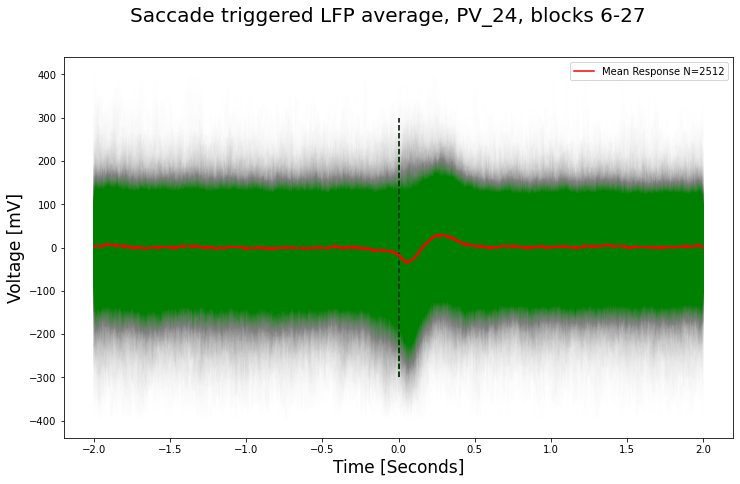

In [59]:
# this is the plotting step:
fig,axes = plt.subplots(figsize=(12,7))

for i in tqdm(range(np.shape(clean_stack)[0])):
    # plot the clean responses
    axes.plot(x_axis,clean_stack[i],alpha=0.002, color='green')
    # plot the zero line

axes.vlines(0,-300,300,linestyles='--')
#axes.plot(x_axis,mean_samples_vector_all,color='blue',label=f'all Mean Response N={np.shape(all_saccade_stack)[0]}')
#axes.plot(x_axis,mean_samples_vector_dirty,color='red',label=f'dirty Mean Response N={np.shape(noise_stack)[0]}')
axes.plot(x_axis,mean_samples_vector_clean,color='red',label=f'Mean Response N={np.shape(clean_stack)[0]}')
# axes.plot(x_axis,mean_samples_vector_all,color='green')
axes.set_xlabel('Time [Seconds]')
axes.set_ylabel('Voltage [mV]')
axes.xaxis.label.set_size(17)
axes.yaxis.label.set_size(17)
plt.suptitle('Saccade triggered LFP average, PV_24, blocks 6-27',fontsize=20)
plt.legend(loc='upper right')
#plt.savefig(fname=r'D:\MarkS3\Pictures\Graphs\SaccadeTriggeredLFPAverage_withShadowTraces_alpha0005.png')


In [7]:
# loop through all dates and all blocks:
p = pathlib.Path(r'Z:\Nimrod\experiments\PV_24')
experiments_path = pathlib.Path(r"Z:\Nimrod\experiments")
animal = "PV_24"
bad_block_list = [1,2,3,4,5,10,22]
date_folder_list = [i for i in p.iterdir() if 'block' not in str(i).lower() and i.is_dir()]
for date_path in date_folder_list:
    date = date_path.name
    # list all blocks in the folder:
    folder_list = [i for i in date_path.iterdir()]
    for block in folder_list:
        block_number = block.name[-3:]
        if int(block_number) not in bad_block_list:
            if int(block_number) < 44:
                #block definition
                block = BlockSync(animal_call=animal,
                                  experiment_date=date,block_num=block_number,
                                  path_to_animal_folder=str(experiments_path))

                analyzed_block_automated_pipe(block)






instantiated block number 006 at Path: Z:\Nimrod\experiments\PV_24\2021_12_26\block_006
Found the sample rate for block 006 in the xml file, it is 20000 Hz
handling eye video files
converting videos...
converting files: ['Z:\\Nimrod\\experiments\\PV_24\\2021_12_26\\block_006\\eye_videos\\LE\\PV24_EE6_640x480_60hz_experiment_1_recording_0\\PV24_EE6.h264', 'Z:\\Nimrod\\experiments\\PV_24\\2021_12_26\\block_006\\eye_videos\\RE\\PV24_EE6_640x480_60hz_experiment_1_recording_0\\PV24_EE6.h264']
The file Z:\Nimrod\experiments\PV_24\2021_12_26\block_006\eye_videos\RE\PV24_EE6_640x480_60hz_experiment_1_recording_0\PV24_EE6.mp4 already exists, no conversion necessary
Validating videos...
The video named PV24_EE6_LE.mp4 has reported 77054 frames and has 77054 frames, it has dropped 0 frames
The video named PV24_EE6.mp4 has reported 77048 frames and has 77048 frames, it has dropped 0 frames
handling arena files
Arena video Names:
back_20211226_145550.mp4
left_20211226_145550.mp4
right_20211226_1455

KeyboardInterrupt: 

In [ ]:
#Collect PSDs on all blocks - for later, INCOMPLETE
p = pathlib.Path(r'Z:\Nimrod\experiments\PV_24')
date_folder_list = [i for i in p.iterdir() if 'block' not in str(i).lower() and i.is_dir()]
for date_path in date_folder_list:
    date = date_path.name
    # list all blocks in the folder:
    folder_list = [i for i in date_path.iterdir()]
    for block in folder_list:
        block_number = block.name[-3:]

In [7]:
# trial and err here

#block definition
experiments_path = pathlib.Path(r"Z:\Nimrod\experiments")
animal = "PV_24"
date = "2021_12_29"
block_n = "023"

block = BlockSync(animal_call=animal,
                  experiment_date=date,block_num=block_n,
                  path_to_animal_folder=str(experiments_path))
# path definition
p = block.oe_path / 'analysis'
p = p / str(os.listdir(p)[0])
matPath = p / 'lizMov.mat'
print(f'path to mat file is {matPath}')

instantiated block number 023 at Path: Z:\Nimrod\experiments\PV_24\2021_12_29\block_023
Found the sample rate for block 023 in the xml file, it is 20000 Hz
path to mat file is Z:\Nimrod\experiments\PV_24\2021_12_29\block_023\oe_files\PV24_29_12_21_EE23_2021-12-29_11-10-57\Record Node 101\analysis\Animal=PV_24,recNames=Block0023\lizMov.mat


In [8]:
analyzed_block_automated_pipe(block)

handling eye video files
converting videos...
converting files: ['Z:\\Nimrod\\experiments\\PV_24\\2021_12_29\\block_023\\eye_videos\\LE\\PV24_EE23_640x480_60hz_experiment_1_recording_0\\PV24_EE23.h264', 'Z:\\Nimrod\\experiments\\PV_24\\2021_12_29\\block_023\\eye_videos\\RE\\PV24_EE23_640x480_60hz_experiment_1_recording_0\\PV24_EE23.h264']
The file Z:\Nimrod\experiments\PV_24\2021_12_29\block_023\eye_videos\RE\PV24_EE23_640x480_60hz_experiment_1_recording_0\PV24_EE23.mp4 already exists, no conversion necessary
Validating videos...
The video named PV24_EE23_LE.mp4 has reported 110928 frames and has 110928 frames, it has dropped 0 frames
The video named PV24_EE23.mp4 has reported 110928 frames and has 110928 frames, it has dropped 0 frames
handling arena files
Arena video Names:
back_20211229_111100.mp4
left_20211229_111100.mp4
right_20211229_111100.mp4
top_20211229_111100.mp4
running parse_open_ephys_events...
events.csv file already exists
L_eye_TTL was not identified as Arena_TTL
the a

In [31]:
# collect saccade events
block.saccade_event_analayzer()

loaded chunked saccade data from analysis folder


In [114]:
# collect timestamps of saccades
l_saccades = block.l_saccades_chunked[block.l_saccades_chunked.saccade_length_frames > 0]
r_saccades = block.r_saccades_chunked[block.r_saccades_chunked.saccade_length_frames > 0]
saccade_times = np.sort(np.concatenate([l_saccades.saccade_start_ms.values,r_saccades.saccade_start_ms.values]))
saccade_ts = block.re_df[block.re_df['ms_axis'].isin(saccade_times)].Arena_TTL.values # translate saccade times to sample based timestamps

In [68]:
# get all the electrophysiology data of a single electrode:
session = oea.Session(str(block.oe_path.parent))
data = session.recordnodes[0].recordings[0].continuous[0].samples[:,17]
timestamps = session.recordnodes[0].recordings[0].continuous[0].timestamps



In [212]:
# now use the saccade_ts vector to choose samples with a given segment length before and after the saccades
segment_length = 40000 #samples
before_saccade_ts = saccade_ts - segment_length
after_saccade_ts = saccade_ts + segment_length
pre_dict = {
    "timestamps":saccade_ts,
    "fs":[],
    "pxx":[],
    "samples":[]
}
post_dict = {
    "timestamps":saccade_ts,
    "fs":[],
    "pxx":[],
    "samples":[]
}
for i in tqdm(range(len(saccade_ts))):
    saccade_sample_ind = np.where(timestamps == int(saccade_ts[i]))[0][0]
    pre_saccade_sample_ind = np.where(timestamps == int(before_saccade_ts[i]))[0][0]
    post_saccade_sample_ind = np.where(timestamps == int(after_saccade_ts[i]))[0][0]
    pre_samples_range = range(pre_saccade_sample_ind,saccade_sample_ind)
    post_samples_range = range(saccade_sample_ind, post_saccade_sample_ind)
    pre_segment_samples = data[pre_samples_range]
    post_segment_samples = data[post_samples_range]
    pre_fs, pre_pxx = sig.welch(pre_segment_samples,block.sample_rate,nperseg=16384,return_onesided=True)
    post_fs, post_pxx = sig.welch(post_segment_samples,block.sample_rate,nperseg=16384,return_onesided=True)
    pre_dict['fs'].append(pre_fs)
    pre_dict['pxx'].append(pre_pxx)
    post_dict['fs'].append(post_fs)
    post_dict['pxx'].append(post_pxx)
    pre_dict['samples'].append(pre_segment_samples)
    post_dict['samples'].append(post_segment_samples)


100%|██████████| 273/273 [00:38<00:00,  7.06it/s]


In [49]:
print(blocklist)

[BlockSync object for animal PV_24 with 
block_num 006 at date PV24_26_12_21_EE6_2021-12-26_14-55-46, BlockSync object for animal PV_24 with 
block_num 007 at date PV24_26_12_21_EE7_2021-12-26_15-23-25, BlockSync object for animal PV_24 with 
block_num 008 at date PV24_26_12_21_EE8_2021-12-26_15-44-32, BlockSync object for animal PV_24 with 
block_num 009 at date PV24_26_12_21_EE9_2021-12-26_16-07-39, BlockSync object for animal PV_24 with 
block_num 011 at date PV24_26_12_21_EE11_2021-12-26_17-12-32, BlockSync object for animal PV_24 with 
block_num 012 at date PV24_27_12_21_EE12_2021-12-27_11-36-41, BlockSync object for animal PV_24 with 
block_num 013 at date PV24_27_12_21_EE13_2021-12-27_12-08-31, BlockSync object for animal PV_24 with 
block_num 014 at date PV24_27_12_21_EE14_2021-12-27_12-40-46, BlockSync object for animal PV_24 with 
block_num 015 at date PV24_27_12_21_EE15_2021-12-27_16-20-24, BlockSync object for animal PV_24 with 
block_num 016 at date PV24_27_12_21_EE16_2021

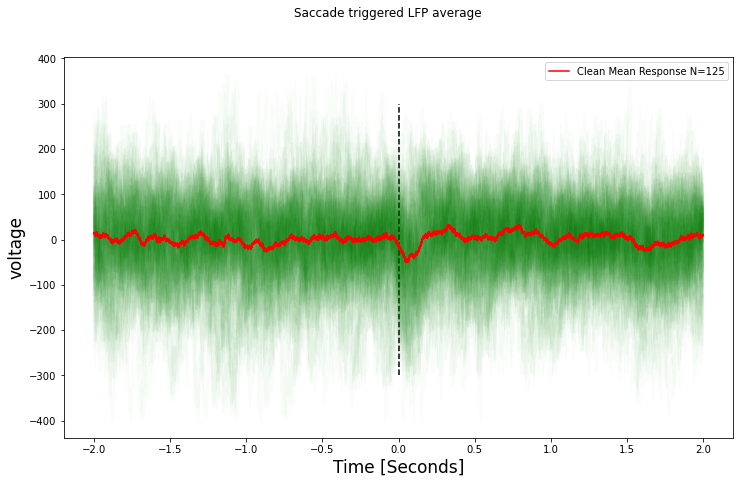

In [317]:
# create a joint mean vector of samples for pre+post

pre_stack = np.vstack(pre_dict["samples"][:])
post_stack = np.vstack(post_dict["samples"][:])
long_stack = np.hstack((pre_stack, post_stack))
clean_stack = []
noise_stack = []
# sift out responses that are clearly noise
for i in range(np.shape(long_stack)[0]):
    if np.max(long_stack[i]) < 400 and np.min(long_stack[i]) > -400:
        clean_stack.append(long_stack[i])
    else:
        noise_stack.append(long_stack[i])
clean_stack = np.vstack(clean_stack)
mean_samples_vector_all = np.mean(long_stack,axis=0)
mean_samples_vector_dirty = np.mean(noise_stack,axis=0)
mean_samples_vector_clean = np.mean(clean_stack,axis=0)
x_axis = (np.array(range(len(mean_samples_vector_clean))) / 20000) - 2
fig,axes = plt.subplots(figsize=(12,7))
# Plot the noise responses
# for i in range(np.shape(noise_stack)[0]):
#    axes.plot(x_axis,noise_stack[i],alpha=0.3)
# plot the clean responses
for i in range(np.shape(clean_stack)[0]):
   axes.plot(x_axis,clean_stack[i],alpha=0.025, color='green')

# plot the zero line
axes.vlines(0,-300,300,linestyles='--')
# axes.plot(x_axis,mean_samples_vector_dirty,color='red')
axes.plot(x_axis,mean_samples_vector_clean,color='red',label=f'Clean Mean Response N={np.shape(clean_stack)[0]}')

# axes.plot(x_axis,mean_samples_vector_all,color='green')
axes.set_xlabel('Time [Seconds]')
axes.set_ylabel('voltage')
axes.xaxis.label.set_size(17)
axes.yaxis.label.set_size(17)
plt.suptitle('Saccade triggered LFP average')
plt.legend()
#plt.savefig(fname=r'D:\MarkS3\Pictures\Graphs\SaccadeTriggeredLFPAverage_b023.png')

In [319]:
# This is a matlab output cell
#saccade_samples_dict = {"saccade_triggered_sample_stack":long_stack}
#io.savemat(r"D:\MarkS3\Documents\NeuroPhysiologyLab_TeachingAssitence\matlab_instruction_files\block_023_saccade_triggered_samples.mat",saccade_samples_dict)

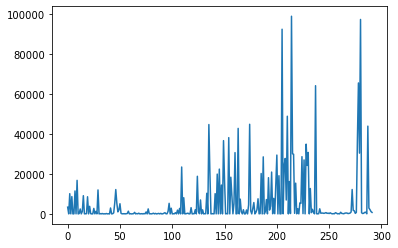

In [322]:
plt.plot(np.diff(saccade_times))

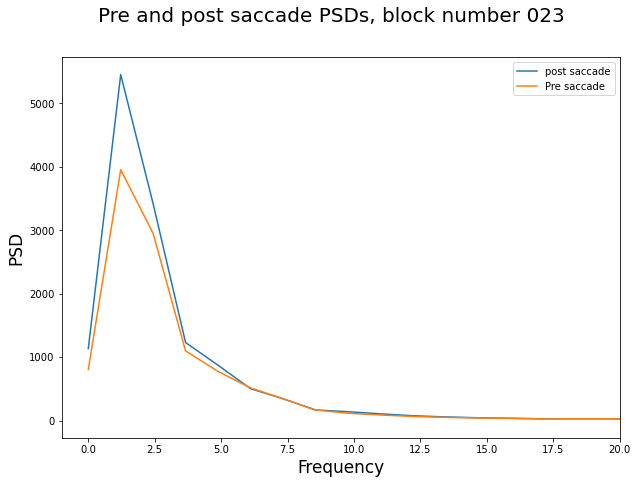

In [211]:
#

post_saccade_mean_pxx = np.mean(np.array(post_dict['pxx']),axis=0)
pre_saccade_mean_pxx = np.mean(np.array(pre_dict['pxx']),axis=0)
post_pre_pxx = post_saccade_mean_pxx - pre_saccade_mean_pxx
fs_vec = post_dict['fs'][0]

fig, axes = plt.subplots(figsize=(10,7))
axes.plot(fs_vec,post_saccade_mean_pxx,label='post saccade')
axes.plot(fs_vec,pre_saccade_mean_pxx,label='Pre saccade')
axes.set_xlim(-1,20)
axes.legend()
fig.suptitle(f'Pre and post saccade PSDs, block number {block.block_num}',fontsize=20)
axes.set_xlabel('Frequency')
axes.set_ylabel('PSD')
axes.xaxis.label.set_size(17)
axes.yaxis.label.set_size(17)

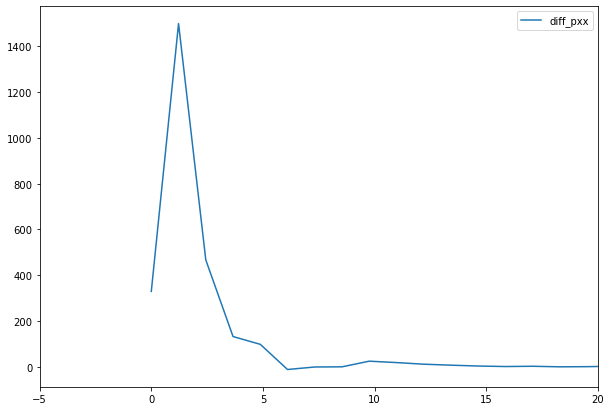

In [203]:
fig, axes = plt.subplots(figsize=(10,7))
axes.plot(fs_vec,post_pre_pxx,label='diff_pxx')

axes.set_xlim(-5,20)
axes.legend()

In [162]:
# see if I can PSD some segment of the data:
seg = data[0:30000]
seg_f, seg_pxx = sig.welch(seg,20000,nperseg=16384,return_onesided=True)


(0.0, 20.0)

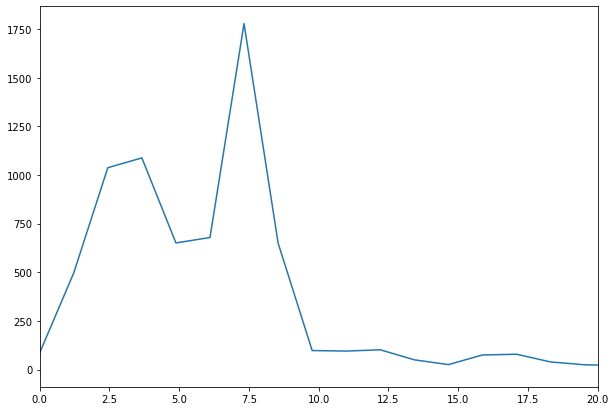

In [163]:
fig, axes = plt.subplots(figsize=(10,7))
axes.plot(seg_f,seg_pxx)
axes.set_xlim(0,20)


In [17]:
# read mat file
matDict = io.loadmat(matPath)
df_dict = {'t_mov_ms':matDict['t_mov_ms'][0,:],
           'movAll':matDict['movAll'][0,:]}
df = pd.DataFrame.from_dict(df_dict)
# The t_mov_ms column indicates the times when threshold-crossing movements occurred in Milliseconds from electrophysiology recording beginning
# the movAll column gives the amplitude of said movements as a combination of the 3D accelerometer channels

In [18]:
# It is now needed to synchronize the timebase so that 0 will be the beginning of synchronized time and not beginning of oe recording
# first, find the very first timestamp of the oe recording
session = oea.Session(str(block.oe_path.parent))
rec_node = session.recordnodes[0].recordings[0].continuous[0]
rec_starts = rec_node.timestamps[0]
# second, find the first arena_TTL oe based timestamp
sync_starts = block.final_sync_df.Arena_TTL[0]


In [19]:
# t_mov_ms should have the Milliseconds between beginning of the recording and beginning of synchronized time subtracted to align 0 with the synctime 0
delta_samples = sync_starts - rec_starts
delta_samples_ms = (delta_samples / block.sample_rate)*1000
synced_t_ms_mov = matDict['t_mov_ms'][0,:] - delta_samples_ms # correction happens here
# now re-create the df
df_dict = {'t_mov_ms': synced_t_ms_mov,
           'movAll': matDict['movAll'][0,:]}
acc_df = pd.DataFrame.from_dict(df_dict)

In [90]:
synced_t_ms_mov

NameError: name 'synced_t_ms_mov' is not defined

In [20]:
acc_df['movAll_z'] = (acc_df.movAll - np.mean(acc_df.movAll)) / acc_df.movAll.std()


In [9]:
x_axis = block.ms_axis
le_x_z = (block.le_df.center_x - np.mean(block.le_df.center_x)) / block.le_df.center_x.std()
le_y_z = (block.le_df.center_y - np.mean(block.le_df.center_y)) / block.le_df.center_y.std()
re_x_z = (block.re_df.center_x - np.mean(block.re_df.center_x)) / block.re_df.center_x.std()
re_y_z = (block.re_df.center_y - np.mean(block.re_df.center_y)) / block.re_df.center_y.std()

b_fig = figure(title=f'Block Number {block.block_num} Synchronization Verification',
               x_axis_label='Milliseconds',
               y_axis_label='Z_score',
               plot_width=1500,
               plot_height=700
               )
b_fig.add_tools(HoverTool())
b_fig.line(x_axis, le_x_z+7, legend_label='Left Eye X Position', line_width=1, line_color='cyan')
b_fig.line(x_axis, le_y_z+3.5, legend_label='Left Eye Y position', line_width=1, line_color='green')
b_fig.line(x_axis, re_x_z+7, legend_label='Right Eye X Position', line_width=1, line_color='orange')
b_fig.line(x_axis, re_y_z+3.5, legend_label='Right Eye Y position', line_width=1, line_color='pink')
b_fig.scatter(acc_df.t_mov_ms,acc_df.movAll_z)
#b_fig.line(x_axis,accel_data, legend_label='accelerometer_samples',line_width=1,line_color='red')
b_output.output_file(filename=str(block.analysis_path / f'LizardMovementSyncTrial_{block.block_num}.html'),
                                 title=f'block {block.block_num} Movement Sync Trial')
b_fig.xaxis.formatter.use_scientific= False
show(b_fig)

In [13]:
# sort the data:
r_saccades = block.r_saccades_chunked[block.r_saccades_chunked.saccade_length_frames > 0]
l_saccades = block.l_saccades_chunked[block.l_saccades_chunked.saccade_length_frames > 0]
# Rolling window based saccade frequency Vs Arousal (movement magnitude)
window_size_ms = 10000
step_size_ms = 1000
end_time = block.re_df.ms_axis.iloc[-1]
flag = False
t0 = 0
window_dict = {
    'mid_time': [],
    'window_size': [],
    'saccade_count_l':[],
    'saccade_count_r':[],
    'pupil_diameter_r': [],
    'pupil_diameter_l': [],
    'mov_magnitude':[]
}
while flag is False:
    bin = [t0, t0+window_size_ms] # define the time window for the computation
    print(bin,end='\r')
    ms_timestamp = t0 + (window_size_ms/2) # place a timestamp in the middle of the window, maybe use later for sequential stuff
    saccade_count_r = len(r_saccades.query('saccade_start_ms > @bin[0] and saccade_start_ms < @bin[1]'))
    saccade_count_l = len(l_saccades.query('saccade_start_ms > @bin[0] and saccade_start_ms < @bin[1]'))
    mov_magnitude = np.sum(acc_df.query('t_mov_ms > @bin[0] and t_mov_ms < @bin[1]').movAll.values)
    pupil_diameter_r = np.mean(block.re_df.query('ms_axis > @bin[0] and ms_axis < @bin[1]').ellipse_size)
    pupil_diameter_l = np.mean(block.le_df.query('ms_axis > @bin[0] and ms_axis < @bin[1]').ellipse_size)

    t0 += step_size_ms

    # add to window dict
    window_dict['mid_time'].append(ms_timestamp)
    window_dict['window_size'].append(window_size_ms)
    window_dict['saccade_count_l'].append(saccade_count_l)
    window_dict['saccade_count_r'].append(saccade_count_r)
    window_dict['mov_magnitude'].append(mov_magnitude)
    window_dict['pupil_diameter_l'].append(pupil_diameter_l)
    window_dict['pupil_diameter_r'].append(pupil_diameter_r)

    if t0+window_size_ms > end_time:
        flag = True
        continue
    else:
        t0 += step_size_ms
        continue

In [14]:
win_df = pd.DataFrame(window_dict)
export_path = pathlib.Path(r"Z:\Nimrod\experiments\PV_24_overall_analysis")
win_df.to_csv(str(export_path / block.block_num) + '.csv')

In [25]:
bin = [0, 10000]
#len(r_saccades.query('saccade_start_ms > @bin[0] and saccade_start_ms < @bin[1]'))
mov_magnitude = np.sum(acc_df.query('t_mov_ms > @bin[0] and t_mov_ms < @bin[1]').movAll.values)
r_saccades.saccade_start_ms.iloc[-1]
block.re_df.ms_axis.iloc[-1]

1837877.85

In [9]:





# chunk the accelerometer readings into movement events
movement_times = acc_df.t_mov_ms[acc_df.t_mov_ms > 0]
mov_start = []
mov_end = []
mov_magnitudes = []
flag = False
row = 0
crit_time = 100 # this is the threshold value for chunking
startpoint = True
while flag is False:
    t1 = movement_times.iloc[row]
    if startpoint: # If this is the starting point, define it
        event_begins = t1
        startpoint = False
    # now, check if the next one exists in the list
    try: # if it does exist:
        t2 = movement_times.iloc[row+1]
    except IndexError: # This means the iteration should stop as we are at the end of the list
        flag = True
        event_ends = t1
        continue

    if np.diff([t1,t2]) < crit_time: # if the two times are close to each other go for another iteration:
        row += 1
        continue
    else: # collect the event times and reset the event_begins
        event_ends = t1
        mov_start.append(event_begins)
        mov_end.append(event_ends)
        startpoint = True
        row += 1
        continue




0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [16]:
movement_dict = {
    'mov_start':mov_start,
    'mov_end' : mov_end
}
mov_df = pd.DataFrame(movement_dict)
mov_df['length'] = mov_df.mov_end - mov_df.mov_start


[]

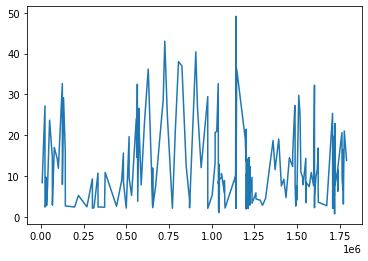

In [14]:
### Build new saccade analyzer here:
#1. Get a time | saccade kind of dataframe
saccade_df = block.r_saccades_chunked[block.r_saccades_chunked.saccade_magnitude > 0]
# create a saccade frequency plot via rolling window


In [68]:
# for each saccade event, collect the 4 seconds around it and
window_size = 4000 #ms
for t in block.l_saccades_chunked.saccade_start_ms:
    t_start = t - window_size
    t_end = t + window_size
    acc_data = acc_df.query("t_mov_ms > t_start & t_mov_ms < t_end")

6176.8
6228.0
6705.7
7337.15
17883.7
21842.9
21962.35
22030.6
30136.45
31979.45
40272.6
40545.55
40699.05
41825.05
45936.55
46038.95
48444.85
51465.2
51687.05
52727.95
69178.35
73001.1
112590.95
115048.25
118222.2
120781.95
121140.25
123717.1
126976.15
127146.75
127180.9
128016.85
128051.0
129774.35
138016.25
138101.6
139330.25
141207.15
141241.25
144176.0
173477.75
173699.65
173921.55
174484.75
176532.6
176617.95
176686.2
176925.1
177283.5
182028.15
204025.8
216039.5
216653.9
218821.2
220681.3
224691.45
227831.45
227865.6
232917.15
241330.15
242695.35
254623.25
255083.95
255732.35
258053.15
258138.5
258189.7
262183.15
267029.6
267336.7
275306.05
275408.4
302953.15
303379.85
303601.7
304130.7
304233.1
370368.45
374993.0
380949.5
390949.65
393407.45
394107.25
398579.15
398801.05
399040.0
399756.9
400951.55
405917.7
408187.5
409467.4
415902.0
415936.1
416038.5
416106.8
416158.0
416482.3
416840.75
416909.05
417506.45
418633.0
418718.35
418769.6
419025.6
419093.9
420288.75
424094.75
424726

In [109]:
# Electrophysiology extraction TAKE 1
session = oea.Session(str(block.oe_path.parent))
rec_node = session.recordnodes[0]
segment = block.final_sync_df.Arena_TTL.astype(int)

oe_timestamps = rec_node.recordings[0].continuous[0].timestamps
accel_data = rec_node.recordings[0].continuous[0].samples[segment,16] # this line is creates a lag because the samples' index system is 0-len(samples) and the OE timestamps system starts on non-zero

In [60]:
# EP extraction take 2
session = oea.Session(str(block.oe_path.parent))
data = session.recordnodes[0].recordings[0].continuous[0]
# data now has the EP recording in it and three fields:
# continuous = the samples themselves (NOT TIMESTAMPED!!)
# timestamps = The OE based timestamps
# metadata = processor ids, etc.
first_oe_timestamp = data.timestamps[0]

In [62]:
# handle the lagged data
lagged_segment = block.final_sync_df.Arena_TTL.astype(int) # it is lagged in relation to the samples, since those start at 0 and OE timestamps start at the first OE timestamp...
corrected_segment = lagged_segment - first_oe_timestamp
accel_data = data.samples[corrected_segment,32]

In [65]:
oe_timestamps = data.timestamps
oe_timestamps

array([ 1568768,  1568769,  1568770, ..., 38882301, 38882302, 38882303],
      dtype=int64)

In [146]:
def extract_channel_electrophysiology(block, channel):
    """
    This function extracts a single electrophysiology channel of the block,
    but only takes those timestamps which are already synchronized without any downsampling or corrections
    :param block: BlockSync object
    :param channels: The channels to extract
    :return:
    """
    session = oea.Session(str(block.oe_path.parent))
    data = session.recordnodes[0].recordings[0].continuous[0]
    first_oe_timestamp = data.timestamps[0]
    lagged_segment = block.final_sync_df.Arena_TTL.astype(int) # it is lagged in relation to the samples, since those start at 0 and OE timestamps start at the first OE timestamp...
    corrected_segment = lagged_segment - first_oe_timestamp
    extraction = data.samples[corrected_segment,channel]
    return extraction

In [17]:
block.analysis_path

WindowsPath('Z:/Nimrod/experiments/PV_24/2021_12_30/block_035/analysis')